## 1a. Classification

This section prepares the dataset, fine-tunes EfficientNet-B7 for breast ultrasound classification, and evaluates performance on the validation split.

In [1]:
# ============================================================
# CELL 1 - IMPORTS AND GLOBAL SETUP
# ============================================================
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Reproducibility seed shared across libraries
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

print("Libraries imported and random seed configured.")

Libraries imported and random seed configured.


In [ ]:
# ============================================================
# CELL 2 - CONFIGURATION
# ============================================================

# Dataset locations (adjust if paths differ in the execution environment)
EXCEL_PATH = "/kaggle/input/tumor-segmentation-ai/training_metadata.xlsx"
IMAGES_ROOT = "/kaggle/input/tumor-segmentation-ai/training_images/training_images"

# Hyperparameters tuned for EfficientNet-B7
# Using 300x300 resolution for faster training while maintaining accuracy
IMG_SIZE = 300
BATCH_SIZE = 24          # Increased batch size for 300x300 on 2x T4 GPU (16GB each)
NUM_WORKERS = 2
NUM_CLASSES = 3

# Class mapping used throughout the project
id2class = {0: "benign", 1: "malignant", 2: "healthy"}
class2id = {v: k for k, v in id2class.items()}

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Configuration: IMG_SIZE={IMG_SIZE}, BATCH={BATCH_SIZE}")
print("Running on:", device)

Configuration: IMG_SIZE=300, BATCH=24
Running on: cuda


### Class-Balanced Data Preparation
The next cell inspects label frequencies and derives inverse-frequency weights so the cross-entropy loss penalises malignant misclassifications more strongly than majority classes.

Dataset loaded: 1503 total images.

Class distribution:
LABEL
0    679
1    364
2    460
Name: count, dtype: int64

Loss weights: [0.7378498 1.3763736 1.0891304]


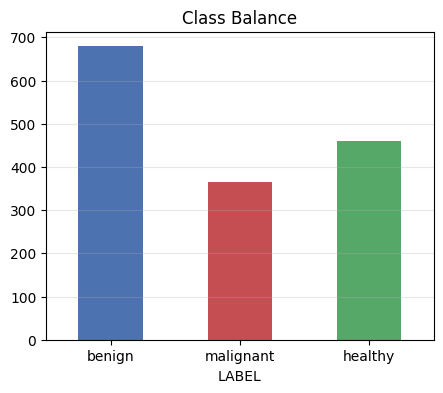

In [3]:
# ============================================================
# CELL 3 - DATA LOADING AND CLASS WEIGHTS
# ============================================================

df = pd.read_excel(EXCEL_PATH)
IMG_COL = "US"
LABEL_COL = "LABEL"

# Basic cleaning: drop rows without an image path or label
df = df.dropna(subset=[IMG_COL, LABEL_COL]).reset_index(drop=True)
print(f"Dataset loaded: {len(df)} total images.")

# Class distribution overview
counts = df[LABEL_COL].value_counts().sort_index()
print("\nClass distribution:")
print(counts)

# Loss weights computed as the inverse of class frequency to counter imbalance
class_counts = counts.values
total_samples = sum(class_counts)
class_weights = [total_samples / (len(class_counts) * c) for c in class_counts]

# Transfer weights to the selected device
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\nLoss weights: {class_weights_tensor.cpu().numpy()}")
# Example: [0.7, 1.3, 1.0] emphasises the malignant class when it is under-represented

plt.figure(figsize=(5, 4))
counts.plot(kind="bar", color=['#4c72b0', '#c44e52', '#55a868'])
plt.xticks(ticks=[0, 1, 2], labels=[id2class[i] for i in [0, 1, 2]], rotation=0)
plt.title("Class Balance")
plt.grid(axis="y", alpha=0.3)
plt.show()

### Augmentation and Loader Design
We now define the augmentation policy, dataset wrapper, and DataLoader settings that keep multi-GPU batches aligned while preserving validation integrity.

In [ ]:
# ============================================================
# CELL 4 - DATASET AND DATALOADER (DROP_LAST ADJUSTMENT)
# ============================================================

# 1. Dataset definition
class UltrasoundDataset(Dataset):
    def __init__(self, df, img_col, label_col, root="", transform=None):
        self.df = df.reset_index(drop=True)
        self.img_col = img_col
        self.label_col = label_col
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def _get_img_path(self, idx):
        path_str = str(self.df.loc[idx, self.img_col])
        if self.root:
            return os.path.join(self.root, path_str)
        return path_str

    def __getitem__(self, idx):
        img_path = self._get_img_path(idx)
        label = int(self.df.loc[idx, self.label_col])

        try:
            # Load as RGB for consistent processing
            pil_img = Image.open(img_path).convert("RGB")
            # Convert to NumPy for Albumentations compatibility
            img_np = np.array(pil_img)
        except Exception as e:
            print(f"Error while loading {img_path}: {e}")
            img_np = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=img_np)
            img = augmented['image']
        else:
            img = T.ToTensor()(pil_img)

        return img, label

# 2. Transformations (CLAHE + elastic augmentations)
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 3. DataLoaders with drop_last enabled for multi-GPU stability
train_df, val_df = train_test_split(df, stratify=df[LABEL_COL], test_size=0.2, random_state=SEED)
print("Train size:", len(train_df), "Val size:", len(val_df))

train_ds = UltrasoundDataset(train_df, IMG_COL, LABEL_COL, IMAGES_ROOT, train_transform)
val_ds = UltrasoundDataset(val_df, IMG_COL, LABEL_COL, IMAGES_ROOT, val_transform)

# drop_last=True prevents GPU imbalance when the last batch is undersized
train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=False  # Validation keeps the final partial batch because BatchNorm is not updated
)

print("DataLoaders initialised with drop_last enabled for training.")

Train size: 1202 Val size: 301
DataLoaders initialised with drop_last enabled for training.


/tmp/ipykernel_23814/1909093045.py:48: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.3),


In [5]:
# ============================================================
# CELL 5 - EFFICIENTNET-B7 MODEL (INPLACE FIX)
# ============================================================

def get_model():
    print("Downloading EfficientNet-B7 weights...")
    weights = models.EfficientNet_B7_Weights.DEFAULT
    model = models.efficientnet_b7(weights=weights)

    # Output dimensionality of EfficientNet-B7 (typically 2560)
    in_features = model.classifier[1].in_features

    # Bottleneck head tailored for this task
    model.classifier = nn.Sequential(
        # Batch normalisation on backbone features
        nn.BatchNorm1d(in_features),

        # Intermediate bottleneck layer
        nn.Linear(in_features, 512),
        nn.ReLU(),

        # Dropout with inplace disabled to avoid RuntimeError during backward passes
        nn.Dropout(p=0.5, inplace=False),

        # Final classification layer
        nn.Linear(512, NUM_CLASSES)
    )

    # Fine-tune all parameters
    for param in model.parameters():
        param.requires_grad = True

    return model

# 1. Instantiate the model
model = get_model()

# 2. Enable DataParallel when multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"{torch.cuda.device_count()} GPUs detected. Enabling DataParallel.")
    model = nn.DataParallel(model)
else:
    print("Single GPU detected.")

# 3. Move to the selected device
model = model.to(device)

print("EfficientNet-B7 with bottleneck head is ready (inplace dropout fix applied).")

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:10<00:00, 25.9MB/s] 


2 GPUs detected. Enabling DataParallel.
EfficientNet-B7 with bottleneck head is ready (inplace dropout fix applied).


### Training Strategy
The following loop implements differential learning rates for backbone and head parameters, logs progress every ten batches, and applies early stopping based on validation balanced accuracy.

In [ ]:
# ============================================================
# CELL 6 - TRAINING LOOP (MULTI-GPU WITH BATCH LOGGING)
# ============================================================

# --- 1. Support functions ---
def train_one_epoch(model, loader, criterion, optimizer, epoch_idx, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Enumerate batches to report progress
    for i, (inputs, labels) in enumerate(loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Progress update every 10 batches
        if (i + 1) % 10 == 0:
            print(f"    [Epoch {epoch_idx + 1}/{total_epochs}] Batch {i + 1}/{len(loader)} -> Loss: {loss.item():.4f}")

    return running_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return running_loss / total, correct / total, balanced_accuracy_score(y_true, y_pred)

# --- 2. Optimiser configuration for multi-GPU training ---

# When DataParallel is active, parameters reside under model.module
if hasattr(model, 'module'):
    print("Configuring parameter groups for multi-GPU training (model.module).")
    backbone_params = model.module.features.parameters()
    head_params = model.module.classifier.parameters()
else:
    print("Configuring parameter groups for single-GPU training.")
    backbone_params = model.features.parameters()
    head_params = model.classifier.parameters()

# Differential learning rates: slower updates for the backbone, faster for the head
optimizer = optim.AdamW([
    {'params': backbone_params, 'lr': 1e-5},
    {'params': head_params, 'lr': 1e-3}
], weight_decay=1e-2)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# --- 3. Training loop ---
NUM_EPOCHS = 100
best_bal_acc = 0
patience_counter = 0
EARLY_STOP_PATIENCE = 15

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_bal_acc': []}

print(f"\nStarting training on {torch.cuda.device_count()} GPU(s).")

for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    # Training phase (epoch index used for progress reporting)
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, NUM_EPOCHS)

    # Validation phase
    val_loss, val_acc, val_bal_acc = validate(model, val_loader, criterion)

    # Step the scheduler with the balanced accuracy
    scheduler.step(val_bal_acc)

    # Retrieve the current learning rate of the head
    current_lr_head = optimizer.param_groups[1]['lr']

    # Track history for visualisation
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_bal_acc'].append(val_bal_acc)

    epoch_time = time.time() - start_time

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} [{epoch_time:.0f}s] | Head LR: {current_lr_head:.1e}")
    print(f"   Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"   Val Loss:   {val_loss:.4f} | Val Balanced Accuracy: {val_bal_acc:.4f}")

    # Model checkpointing
    if val_bal_acc > best_bal_acc:
        best_bal_acc = val_bal_acc

        # Save in a format compatible with both single and multi-GPU settings
        if hasattr(model, 'module'):
            torch.save(model.module.state_dict(), "best_model_b7_dual.pt")
        else:
            torch.save(model.state_dict(), "best_model_b7_dual.pt")

        print("   Improvement detected; model checkpoint saved.")
        patience_counter = 0

    else:
        patience_counter += 1
        print(f"   No improvement ({patience_counter}/{EARLY_STOP_PATIENCE}).")
        if patience_counter >= EARLY_STOP_PATIENCE:
            print("   Early stopping triggered.")
            break

print(f"\nTraining completed. Best balanced accuracy: {best_bal_acc:.4f}")

Configuring parameter groups for multi-GPU training (model.module).

Starting training on 2 GPU(s).
    [Epoch 1/80] Batch 10/50 -> Loss: 1.4061
    [Epoch 1/80] Batch 20/50 -> Loss: 1.0531
    [Epoch 1/80] Batch 30/50 -> Loss: 0.9730
    [Epoch 1/80] Batch 40/50 -> Loss: 1.0720
    [Epoch 1/80] Batch 50/50 -> Loss: 1.3215
Epoch 1/80 [60s] | Head LR: 1.0e-03
   Train Loss: 1.1423 | Train Accuracy: 0.5033
   Val Loss:   1.5363 | Val Balanced Accuracy: 0.4615
   Improvement detected; model checkpoint saved.
    [Epoch 2/80] Batch 10/50 -> Loss: 0.8016
    [Epoch 2/80] Batch 20/50 -> Loss: 0.7280
    [Epoch 2/80] Batch 30/50 -> Loss: 0.8485
    [Epoch 2/80] Batch 40/50 -> Loss: 0.7353
    [Epoch 2/80] Batch 50/50 -> Loss: 1.0031
Epoch 2/80 [57s] | Head LR: 1.0e-03
   Train Loss: 0.9830 | Train Accuracy: 0.5917
   Val Loss:   1.2076 | Val Balanced Accuracy: 0.5015
   Improvement detected; model checkpoint saved.
    [Epoch 3/80] Batch 10/50 -> Loss: 0.7162
    [Epoch 3/80] Batch 20/50 -> L

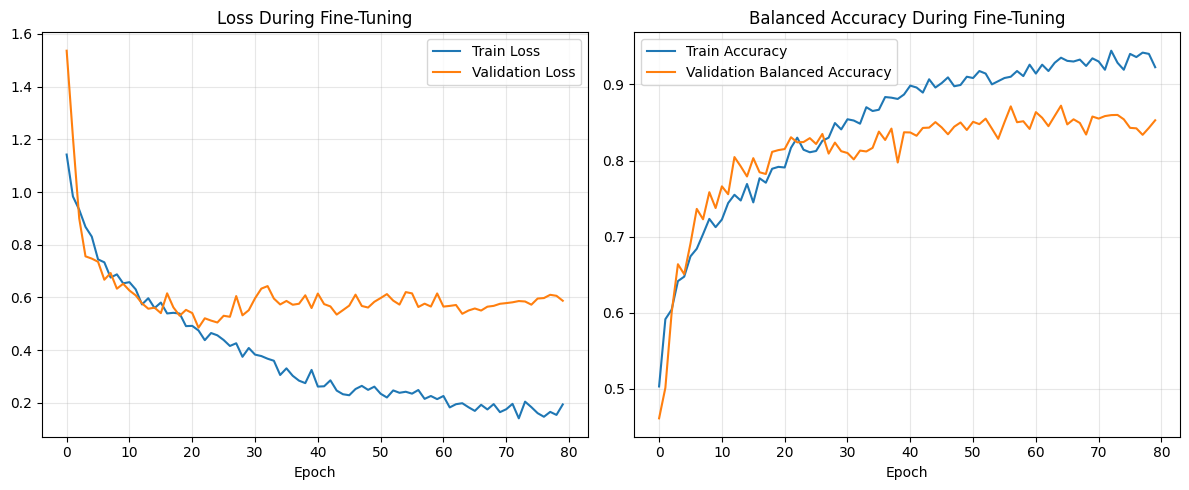

In [7]:
# ============================================================
# CELL 7 - TRAINING CURVES
# ============================================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Loss During Fine-Tuning")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_bal_acc'], label='Validation Balanced Accuracy')
plt.title("Balanced Accuracy During Fine-Tuning")
plt.xlabel("Epoch")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Evaluation Overview.** The following cells restore the best EfficientNet-B7 checkpoint and provide both tabular and graphical assessments, followed by a test-time augmentation study.

Best classification model loaded for evaluation.
Generating predictions...

--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

      benign       0.88      0.85      0.86       136
   malignant       0.84      0.84      0.84        73
     healthy       0.89      0.93      0.91        92

    accuracy                           0.87       301
   macro avg       0.87      0.87      0.87       301
weighted avg       0.87      0.87      0.87       301



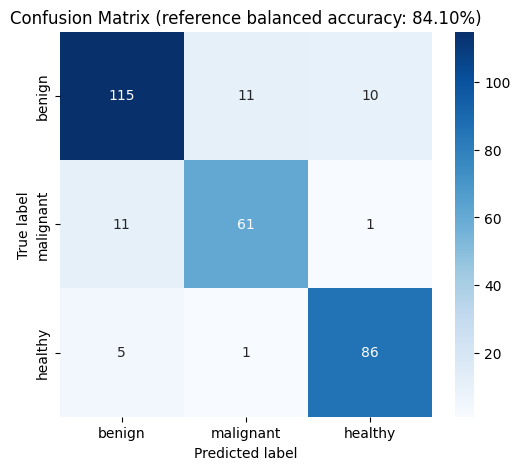

In [8]:
# ============================================================
# CELL 8 - DETAILED EVALUATION
# ============================================================
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Load the best checkpoint
# Recreate a clean instance (without DataParallel wrapping) for evaluation
model_eval = get_model()

# If saved via model.module.state_dict(), keys are already clean
# When saved via model.state_dict() under DataParallel, prefixes such as "module." appear
state_dict = torch.load("best_model_b7_dual.pt", map_location=device)

# Remove the optional "module." prefix for compatibility
new_state_dict = {}
for k, v in state_dict.items():
    name = k.replace("module.", "")
    new_state_dict[name] = v

model_eval.load_state_dict(new_state_dict)
model_eval = model_eval.to(device)
model_eval.eval()

print("Best classification model loaded for evaluation.")

# 2. Predictions across the validation loader
y_true, y_pred = [], []
y_probs = []

print("Generating predictions...")
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model_eval(inputs)

        # Probabilities retained for optional downstream analysis (e.g., ROC curves or TTA)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

# 3. Textual report
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred, target_names=[id2class[i] for i in range(3)]))

# 4. Confusion matrix visualisation
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=id2class.values(), yticklabels=id2class.values())
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

### Test-Time Augmentation Study
To assess robustness, we average predictions over original, horizontally flipped, and vertically flipped views before recomputing balanced accuracy and reporting the updated classification metrics.

In [9]:
# ============================================================
# CELL 9 - TEST TIME AUGMENTATION (TTA)
# ============================================================

def predict_tta(model, loader):
    model.eval()
    all_probs = []
    all_labels = []

    print("Running TTA (original, horizontal flip, vertical flip)...")

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            all_labels.extend(labels.cpu().numpy())

            # 1. Original prediction
            out1 = model(inputs)
            prob1 = torch.softmax(out1, dim=1)

            # 2. Horizontal flip prediction
            inputs_h = torch.flip(inputs, dims=[3])  # Axis 3 corresponds to width
            out2 = model(inputs_h)
            prob2 = torch.softmax(out2, dim=1)

            # 3. Vertical flip prediction
            inputs_v = torch.flip(inputs, dims=[2])  # Axis 2 corresponds to height
            out3 = model(inputs_v)
            prob3 = torch.softmax(out3, dim=1)

            # Average the probability distributions
            avg_prob = (prob1 + prob2 + prob3) / 3.0
            all_probs.extend(avg_prob.cpu().numpy())

    return np.array(all_labels), np.array(all_probs)

# Execute TTA
y_true_tta, y_probs_tta = predict_tta(model_eval, val_loader)
y_pred_tta = np.argmax(y_probs_tta, axis=1)

# Balanced accuracy with TTA
tta_acc = balanced_accuracy_score(y_true_tta, y_pred_tta)
print(f"\nBalanced accuracy without TTA: 0.8410")
print(f"Balanced accuracy with TTA:  {tta_acc:.4f}")

# Report the improvement for traceability
print("\nClassification report (TTA):")
print(classification_report(y_true_tta, y_pred_tta, target_names=[id2class[i] for i in range(3)]))

Running TTA (original, horizontal flip, vertical flip)...

Balanced accuracy without TTA: 0.8410
Balanced accuracy with TTA:  0.8741

Classification report (TTA):
              precision    recall  f1-score   support

      benign       0.88      0.84      0.86       136
   malignant       0.84      0.85      0.84        73
     healthy       0.88      0.93      0.91        92

    accuracy                           0.87       301
   macro avg       0.87      0.87      0.87       301
weighted avg       0.87      0.87      0.87       301



## 📊 Comprehensive Classification Analysis for Academic Paper
The following cells provide detailed statistical analysis, publication-quality visualizations, and comprehensive metrics required for scientific reporting of the classification model performance.

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 1: ROC CURVES & AUC SCORES
# ============================================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import warnings
warnings.filterwarnings('ignore')

# Convert predictions to numpy arrays
y_true_np = np.array(y_true)
y_probs_np = np.array(y_probs)
y_pred_np = np.array(y_pred)

# Binarize the labels for multi-class ROC
y_true_bin = label_binarize(y_true_np, classes=[0, 1, 2])
n_classes = 3

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs_np[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_probs_np.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual class ROC curves
colors = ['#2ecc71', '#e74c3c', '#3498db']
class_names = ['Benign', 'Malignant', 'Healthy']

ax1 = axes[0]
for i, (color, name) in enumerate(zip(colors, class_names)):
    ax1.plot(fpr[i], tpr[i], color=color, lw=2.5,
             label=f'{name} (AUC = {roc_auc[i]:.4f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves per Class (One-vs-Rest)', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right", fontsize=11)
ax1.grid(True, alpha=0.3)

# Micro and Macro average ROC curves
ax2 = axes[1]
ax2.plot(fpr["micro"], tpr["micro"], color='#9b59b6', lw=2.5, linestyle=':',
         label=f'Micro-average (AUC = {roc_auc["micro"]:.4f})')
ax2.plot(fpr["macro"], tpr["macro"], color='#e67e22', lw=2.5, linestyle='--',
         label=f'Macro-average (AUC = {roc_auc["macro"]:.4f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate', fontsize=12)
ax2.set_title('Aggregated ROC Curves', fontsize=14, fontweight='bold')
ax2.legend(loc="lower right", fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("RECEIVER OPERATING CHARACTERISTIC (ROC) ANALYSIS SUMMARY")
print("="*70)
print(f"\n{'Class':<15} {'AUC Score':<12} {'Interpretation'}")
print("-"*50)
for i, name in enumerate(class_names):
    interp = "Excellent" if roc_auc[i] >= 0.9 else "Good" if roc_auc[i] >= 0.8 else "Fair"
    print(f"{name:<15} {roc_auc[i]:<12.4f} {interp}")
print("-"*50)
print(f"{'Macro-average':<15} {roc_auc['macro']:<12.4f}")
print(f"{'Micro-average':<15} {roc_auc['micro']:<12.4f}")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 2: PRECISION-RECALL CURVES
# ============================================================

# Compute Precision-Recall curves for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_probs_np[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_probs_np[:, i])

# Compute micro-average precision-recall
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_true_bin.ravel(), y_probs_np.ravel())
average_precision["micro"] = average_precision_score(y_true_bin, y_probs_np, average="micro")

# Plot Precision-Recall curves
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Individual class PR curves
ax1 = axes[0]
for i, (color, name) in enumerate(zip(colors, class_names)):
    ax1.plot(recall[i], precision[i], color=color, lw=2.5,
             label=f'{name} (AP = {average_precision[i]:.4f})')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision', fontsize=12)
ax1.set_title('Precision-Recall Curves per Class', fontsize=14, fontweight='bold')
ax1.legend(loc="lower left", fontsize=11)
ax1.grid(True, alpha=0.3)

# Micro-average PR curve with iso-F1 curves
ax2 = axes[1]
f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    ax2.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.3)
    ax2.annotate(f'F1={f_score:.1f}', xy=(0.9, y[45] + 0.02), fontsize=9, alpha=0.6)

ax2.plot(recall["micro"], precision["micro"], color='#9b59b6', lw=2.5,
         label=f'Micro-average (AP = {average_precision["micro"]:.4f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Micro-average PR Curve with Iso-F1 Contours', fontsize=14, fontweight='bold')
ax2.legend(loc="lower left", fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*70)
print("PRECISION-RECALL ANALYSIS SUMMARY")
print("="*70)
print(f"\n{'Class':<15} {'Average Precision':<20} {'Interpretation'}")
print("-"*55)
for i, name in enumerate(class_names):
    interp = "Excellent" if average_precision[i] >= 0.9 else "Good" if average_precision[i] >= 0.8 else "Fair"
    print(f"{name:<15} {average_precision[i]:<20.4f} {interp}")
print("-"*55)
print(f"{'Micro-average':<15} {average_precision['micro']:<20.4f}")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 3: DETAILED METRICS TABLE
# ============================================================
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, cohen_kappa_score, matthews_corrcoef,
                            balanced_accuracy_score)

# Compute all metrics
metrics_summary = {
    'Metric': [],
    'Value': [],
    'Description': []
}

# Overall metrics
overall_acc = accuracy_score(y_true_np, y_pred_np)
balanced_acc = balanced_accuracy_score(y_true_np, y_pred_np)
macro_precision = precision_score(y_true_np, y_pred_np, average='macro')
macro_recall = recall_score(y_true_np, y_pred_np, average='macro')
macro_f1 = f1_score(y_true_np, y_pred_np, average='macro')
weighted_f1 = f1_score(y_true_np, y_pred_np, average='weighted')
kappa = cohen_kappa_score(y_true_np, y_pred_np)
mcc = matthews_corrcoef(y_true_np, y_pred_np)

# Create metrics dictionary
overall_metrics = {
    'Overall Accuracy': (overall_acc, 'Proportion of correct predictions'),
    'Balanced Accuracy': (balanced_acc, 'Average recall per class (handles imbalance)'),
    'Macro Precision': (macro_precision, 'Average precision across classes'),
    'Macro Recall': (macro_recall, 'Average recall (sensitivity) across classes'),
    'Macro F1-Score': (macro_f1, 'Harmonic mean of macro precision and recall'),
    'Weighted F1-Score': (weighted_f1, 'F1 weighted by class support'),
    'Cohen\'s Kappa': (kappa, 'Agreement beyond chance (>0.8 = almost perfect)'),
    'Matthews Corr. Coef.': (mcc, 'Balanced measure for multiclass (-1 to 1)')
}

# Print comprehensive metrics table
print("\n" + "="*80)
print("COMPREHENSIVE CLASSIFICATION METRICS SUMMARY")
print("="*80)
print(f"\n{'Metric':<25} {'Value':<10} {'Description'}")
print("-"*80)
for metric, (value, desc) in overall_metrics.items():
    print(f"{metric:<25} {value:<10.4f} {desc}")
print("-"*80)

# Per-class detailed metrics
print("\n" + "="*80)
print("PER-CLASS PERFORMANCE METRICS")
print("="*80)
print(f"\n{'Class':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-"*60)

per_class_precision = precision_score(y_true_np, y_pred_np, average=None)
per_class_recall = recall_score(y_true_np, y_pred_np, average=None)
per_class_f1 = f1_score(y_true_np, y_pred_np, average=None)

from collections import Counter
support = Counter(y_true_np)

for i, name in enumerate(class_names):
    print(f"{name:<12} {per_class_precision[i]:<12.4f} {per_class_recall[i]:<12.4f} "
          f"{per_class_f1[i]:<12.4f} {support[i]:<10}")
print("-"*60)

# Clinical interpretation
print("\n" + "="*80)
print("CLINICAL INTERPRETATION")
print("="*80)
print(f"""
Sensitivity (Malignant): {per_class_recall[1]:.2%}
  - Proportion of actual malignant cases correctly identified
  - Critical for cancer screening to minimize false negatives

Specificity (Benign vs Malignant): {per_class_recall[0]:.2%}
  - Proportion of benign cases correctly identified
  - Important to avoid unnecessary interventions

Positive Predictive Value (Malignant): {per_class_precision[1]:.2%}
  - When predicting malignant, probability it's correct
  - Indicates reliability of positive diagnoses
""")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 4: ENHANCED CONFUSION MATRIX
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts confusion matrix
cm_abs = confusion_matrix(y_true_np, y_pred_np)
ax1 = axes[0]
sns.heatmap(cm_abs, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 14, 'weight': 'bold'})
ax1.set_title('Confusion Matrix (Absolute Counts)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# Normalized confusion matrix (percentages)
cm_norm = cm_abs.astype('float') / cm_abs.sum(axis=1)[:, np.newaxis] * 100
ax2 = axes[1]
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax2,
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 14, 'weight': 'bold'},
            vmin=0, vmax=100)
ax2.set_title('Confusion Matrix (Normalized %)', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=12)
ax2.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('classification_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

# Print confusion matrix analysis
print("\n" + "="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)
print("\nAbsolute Confusion Matrix:")
print(f"{'':>12}", end='')
for name in class_names:
    print(f"{name:>12}", end='')
print()
for i, name in enumerate(class_names):
    print(f"{name:>12}", end='')
    for j in range(n_classes):
        print(f"{cm_abs[i,j]:>12d}", end='')
    print()

print("\n\nKey Observations:")
print(f"  - True Positives (diagonal): {np.trace(cm_abs)} / {cm_abs.sum()} ({np.trace(cm_abs)/cm_abs.sum()*100:.1f}%)")
print(f"  - Most common misclassification: ", end='')
cm_off_diag = cm_abs.copy()
np.fill_diagonal(cm_off_diag, 0)
max_idx = np.unravel_index(cm_off_diag.argmax(), cm_off_diag.shape)
print(f"{class_names[max_idx[0]]} → {class_names[max_idx[1]]} ({cm_off_diag[max_idx]} cases)")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 5: TRAINING DYNAMICS ANALYSIS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Loss curves with smoothing
ax1 = axes[0, 0]
epochs = range(1, len(history['train_loss']) + 1)

# Original curves (light)
ax1.plot(epochs, history['train_loss'], alpha=0.3, color='blue')
ax1.plot(epochs, history['val_loss'], alpha=0.3, color='red')

# Smoothed curves (exponential moving average)
def smooth(y, factor=0.85):
    smoothed = []
    for i, val in enumerate(y):
        if i == 0:
            smoothed.append(val)
        else:
            smoothed.append(factor * smoothed[-1] + (1 - factor) * val)
    return smoothed

ax1.plot(epochs, smooth(history['train_loss']), color='blue', lw=2.5, label='Train Loss (smoothed)')
ax1.plot(epochs, smooth(history['val_loss']), color='red', lw=2.5, label='Val Loss (smoothed)')
ax1.axvline(x=np.argmin(history['val_loss'])+1, color='green', linestyle='--', 
            label=f'Best epoch: {np.argmin(history["val_loss"])+1}')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Accuracy curves
ax2 = axes[0, 1]
ax2.plot(epochs, history['train_acc'], alpha=0.3, color='blue')
ax2.plot(epochs, history['val_bal_acc'], alpha=0.3, color='red')
ax2.plot(epochs, smooth(history['train_acc']), color='blue', lw=2.5, label='Train Accuracy (smoothed)')
ax2.plot(epochs, smooth(history['val_bal_acc']), color='red', lw=2.5, label='Val Balanced Acc (smoothed)')
ax2.axhline(y=max(history['val_bal_acc']), color='green', linestyle='--', alpha=0.7,
            label=f'Best Val Acc: {max(history["val_bal_acc"]):.4f}')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Overfitting gap analysis
ax3 = axes[1, 0]
overfitting_gap = np.array(history['train_acc']) - np.array(history['val_bal_acc'])
ax3.fill_between(epochs, 0, overfitting_gap, where=(overfitting_gap > 0), 
                 alpha=0.5, color='red', label='Overfitting region')
ax3.fill_between(epochs, 0, overfitting_gap, where=(overfitting_gap <= 0), 
                 alpha=0.5, color='green', label='Underfitting region')
ax3.axhline(y=0, color='black', linestyle='-', lw=1)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Train - Val Accuracy Gap', fontsize=12)
ax3.set_title('Generalization Gap Analysis', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Learning rate effect (loss derivative)
ax4 = axes[1, 1]
loss_diff = np.diff(history['val_loss'])
ax4.bar(range(1, len(loss_diff)+1), loss_diff, color=['green' if d < 0 else 'red' for d in loss_diff], alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', lw=1)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Validation Loss Change', fontsize=12)
ax4.set_title('Epoch-wise Loss Improvement', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_training_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print training statistics
print("\n" + "="*70)
print("TRAINING DYNAMICS SUMMARY")
print("="*70)
print(f"\n{'Metric':<35} {'Value':<15}")
print("-"*50)
print(f"{'Total epochs trained':<35} {len(history['train_loss']):<15}")
print(f"{'Best validation epoch':<35} {np.argmin(history['val_loss'])+1:<15}")
print(f"{'Final training loss':<35} {history['train_loss'][-1]:<15.4f}")
print(f"{'Final validation loss':<35} {history['val_loss'][-1]:<15.4f}")
print(f"{'Best validation loss':<35} {min(history['val_loss']):<15.4f}")
print(f"{'Final train accuracy':<35} {history['train_acc'][-1]:<15.4f}")
print(f"{'Best val balanced accuracy':<35} {max(history['val_bal_acc']):<15.4f}")
print(f"{'Average overfitting gap (last 10)':<35} {np.mean(overfitting_gap[-10:]):<15.4f}")

In [ ]:
# ============================================================
# CLASSIFICATION ANALYSIS - PART 6: CONFIDENCE ANALYSIS
# ============================================================

# Analyze prediction confidence
y_probs_max = np.max(y_probs_np, axis=1)  # Maximum probability (confidence)
correct_mask = y_true_np == y_pred_np

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confidence distribution for correct vs incorrect predictions
ax1 = axes[0, 0]
ax1.hist(y_probs_max[correct_mask], bins=30, alpha=0.7, color='green', 
         label=f'Correct (n={correct_mask.sum()})', density=True)
ax1.hist(y_probs_max[~correct_mask], bins=30, alpha=0.7, color='red', 
         label=f'Incorrect (n={(~correct_mask).sum()})', density=True)
ax1.set_xlabel('Prediction Confidence', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Confidence Distribution: Correct vs Incorrect', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# 2. Reliability diagram (calibration curve)
ax2 = axes[0, 1]
n_bins = 10
bin_boundaries = np.linspace(0, 1, n_bins + 1)
bin_lowers = bin_boundaries[:-1]
bin_uppers = bin_boundaries[1:]

accuracies = []
confidences = []
bin_counts = []

for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
    in_bin = (y_probs_max > bin_lower) & (y_probs_max <= bin_upper)
    if in_bin.sum() > 0:
        accuracies.append(correct_mask[in_bin].mean())
        confidences.append(y_probs_max[in_bin].mean())
        bin_counts.append(in_bin.sum())
    else:
        accuracies.append(np.nan)
        confidences.append((bin_lower + bin_upper) / 2)
        bin_counts.append(0)

ax2.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect calibration')
ax2.bar(confidences, accuracies, width=0.08, alpha=0.7, color='steelblue', 
        edgecolor='black', label='Model calibration')
ax2.set_xlabel('Mean Predicted Confidence', fontsize=12)
ax2.set_ylabel('Fraction of Positives (Accuracy)', fontsize=12)
ax2.set_title('Reliability Diagram (Calibration Curve)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

# 3. Per-class confidence boxplot
ax3 = axes[1, 0]
confidence_by_class = [y_probs_max[y_pred_np == i] for i in range(n_classes)]
bp = ax3.boxplot(confidence_by_class, labels=class_names, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_xlabel('Predicted Class', fontsize=12)
ax3.set_ylabel('Prediction Confidence', fontsize=12)
ax3.set_title('Confidence Distribution by Predicted Class', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# 4. Confidence threshold analysis
ax4 = axes[1, 1]
thresholds = np.linspace(0.3, 0.99, 50)
coverage = []
accuracy_at_threshold = []

for thresh in thresholds:
    above_thresh = y_probs_max >= thresh
    coverage.append(above_thresh.sum() / len(y_probs_max))
    if above_thresh.sum() > 0:
        accuracy_at_threshold.append(correct_mask[above_thresh].mean())
    else:
        accuracy_at_threshold.append(np.nan)

ax4.plot(thresholds, coverage, 'b-', lw=2.5, label='Coverage')
ax4.plot(thresholds, accuracy_at_threshold, 'g-', lw=2.5, label='Accuracy')
ax4.set_xlabel('Confidence Threshold', fontsize=12)
ax4.set_ylabel('Proportion', fontsize=12)
ax4.set_title('Coverage vs Accuracy Trade-off', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('classification_confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print confidence statistics
print("\n" + "="*70)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*70)
print(f"\n{'Statistic':<40} {'Value':<15}")
print("-"*55)
print(f"{'Mean confidence (all predictions)':<40} {y_probs_max.mean():<15.4f}")
print(f"{'Mean confidence (correct predictions)':<40} {y_probs_max[correct_mask].mean():<15.4f}")
print(f"{'Mean confidence (incorrect predictions)':<40} {y_probs_max[~correct_mask].mean():<15.4f}")
print(f"{'Std confidence (all predictions)':<40} {y_probs_max.std():<15.4f}")
print(f"{'Predictions with confidence > 0.9':<40} {(y_probs_max > 0.9).sum():<15} ({(y_probs_max > 0.9).mean()*100:.1f}%)")
print(f"{'Predictions with confidence < 0.5':<40} {(y_probs_max < 0.5).sum():<15} ({(y_probs_max < 0.5).mean()*100:.1f}%)")

## 1b. Segmentation

The segmentation stage focuses on lesion delineation using a MAnet architecture, starting from the same train/validation split to avoid data leakage.

In [ ]:
# ============================================================
# CELL 1 - ENVIRONMENT SETUP AND SOTA LIBRARIES
# ============================================================
# Install the standard library used for advanced segmentation models (left in place for notebook reproducibility)
!pip install segmentation_models_pytorch -q

import segmentation_models_pytorch as smp

# Reuse the global random seed for segmentation experiments
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Configuration
EXCEL_PATH = "/kaggle/input/tumor-segmentation-ai/training_metadata.xlsx"
IMAGES_ROOT = "/kaggle/input/tumor-segmentation-ai/training_images/training_images"
IMG_SIZE = 320       # Resolution for U-Net++ with EfficientNet-B7 encoder (multiple of 32)
BATCH_SIZE = 16      # Increased batch size for 320x320 on 2x T4 GPU (16GB each)
NUM_EPOCHS = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"U-Net++ setup initialised on {device}.")

MAnet setup initialised on cuda.


**Segmentation Stage Overview.** The following cells mirror the classification split, remove healthy cases only after the split to eliminate leakage, and configure MAnet with attention-based decoding for lesion delineation.

In [23]:
# ============================================================
# CELL 2 - DATA PREPARATION (LEAKAGE PREVENTION)
# ============================================================

# 1. Load the full DataFrame (consistent with the classification notebook)
df_full = pd.read_excel(EXCEL_PATH)
df_full = df_full.dropna(subset=['US', 'LABEL', 'MASK']).reset_index(drop=True)

# 2. Perform the split before filtering so it matches the classifier split
# This guarantees that train_full and val_full mirror the previous notebook
train_full, val_full = train_test_split(df_full, stratify=df_full['LABEL'], test_size=0.2, random_state=SEED)

print("Initial split (aligned with the classifier):")
print(f"  Total train: {len(train_full)}")
print(f"  Total validation: {len(val_full)}")

# 3. Post-split filtering (remove normal cases only after the split)
# Retain only benign (0) and malignant (1) records in each subset
train_seg = train_full[train_full['LABEL'] != 2].reset_index(drop=True)
val_seg = val_full[val_full['LABEL'] != 2].reset_index(drop=True)

print("\nSegmentation dataset after filtering (benign/malignant only):")
print(f"  Train segmentation: {len(train_seg)} (subset of the classifier training set)")
print(f"  Validation segmentation: {len(val_seg)} (unseen during classifier training)")

# 4. Dataset class (mirrors the earlier design)
class SegmentationDataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.df = df
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, str(self.df.loc[idx, "US"]))
        mask_path = os.path.join(self.root, str(self.df.loc[idx, "MASK"]))

        try:
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path).convert("L"))
        except Exception:
            image = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
            mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.uint8)

        mask = np.where(mask > 0, 1.0, 0.0).astype(np.float32)

        if self.transform:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        mask = mask.unsqueeze(0)
        return image, mask

# 5. Augmentation pipeline (aligned with the classification transformations)
train_transform = A.Compose([
    # Risoluzione: Se la GPU regge, 320 è meglio di 256 per i dettagli
    A.Resize(IMG_SIZE, IMG_SIZE),
    
    # --- GEOMETRICHE (Movimento della sonda) ---
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),     # Qui va bene: una forma è una forma, anche capovolta
    A.Rotate(limit=30, p=0.5), # Rotazioni più ampie ok per segmentazione
    
    # --- DEFORMAZIONI FISICHE (Qui SI che servono!) ---
    # Simulano la pressione della sonda e la variabilità biologica.
    # Abbiamo ridotto leggermente l'intensità per evitare di "rompere" le immagini piccole
    A.ElasticTransform(alpha=80, sigma=80 * 0.05, alpha_affine=None, p=0.4),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.3),
    
    # --- TEXTURE & RUMORE (Speckle Noise) ---
    # Fondamentale per generalizzare su macchine diverse
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    
    # --- CONTRASTO (Visibilità bordi) ---
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
    
    # --- CHIUSURA ---
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 6. CALCOLO PESI SAMPLER (Solo su B e M)
# Contiamo i Benigni (0) e Maligni (1) nel train set
class_counts = train_seg['LABEL'].value_counts().sort_index()
# Peso inverso (Maligni avranno peso doppio dei Benigni)
class_weights = 1.0 / class_counts
# Assegna peso a ogni immagine
sample_weights = train_seg['LABEL'].map(class_weights).values
sample_weights = torch.from_numpy(sample_weights).double()

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_seg), replacement=True)
print(f"Sampler Attivo: Bilanciamento B ({class_counts[0]}) vs M ({class_counts[1]})")

# 7. DATALOADERS
train_loader = DataLoader(
    SegmentationDataset(train_seg, IMAGES_ROOT, train_transform), 
    batch_size=BATCH_SIZE, 
    sampler=sampler,  # <--- FORZA IL BILANCIAMENTO 50/50
    shuffle=False, 
    num_workers=2, 
    drop_last=True
)

val_loader = DataLoader(
    SegmentationDataset(val_seg, IMAGES_ROOT, val_transform), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=2
)

print("✅ Dataloaders B/M pronti (con Sampler).")

Initial split (aligned with the classifier):
  Total train: 1202
  Total validation: 301

Segmentation dataset after filtering (benign/malignant only):
  Train segmentation: 834 (subset of the classifier training set)
  Validation segmentation: 209 (unseen during classifier training)
Sampler Attivo: Bilanciamento B (543) vs M (291)
✅ Dataloaders B/M pronti (con Sampler).


/tmp/ipykernel_23814/457669398.py:70: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=80, sigma=80 * 0.05, alpha_affine=None, p=0.4),
/tmp/ipykernel_23814/457669398.py:75: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [24]:
# ============================================================
# CELL 3 - SOTA MODEL: U-NET++
# ============================================================

# U-Net++ with Nested Skip Pathways is widely considered SOTA for medical segmentation.
# It bridges the semantic gap between encoder and decoder more effectively than standard U-Net.

ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = 1
ACTIVATION = None

# Switching to UnetPlusPlus
model = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=CLASSES,
    activation=ACTIVATION,
    decoder_channels=(256, 128, 64, 32, 16), # Classic high-res decoder
    decoder_attention_type=None,
    deep_supervision=True
)

if torch.cuda.device_count() > 1:
    print(f"🔥 {torch.cuda.device_count()} GPU attive! DataParallel ON.")
    model = nn.DataParallel(model)

model = model.to(device)

print(f"🚀 SOTA Model U-Net++ initialized with {ENCODER} backbone.")

🔥 2 GPU attive! DataParallel ON.
🚀 SOTA Model U-Net++ initialized with efficientnet-b7 backbone.


### Optimisation Scheme
The next block defines the hybrid Dice–Focal loss, an adaptive learning-rate schedule, and an early-stopping routine tuned to maximise validation Dice.

In [ ]:
# ============================================================
# CELL 4 - SOTA TRAINING (U-NET++ WITH BOUNDARY LOSS)
# ============================================================

# 1. Hybrid Loss Definition (Dice + Focal + Boundary)
loss_dice = smp.losses.DiceLoss(mode='binary', from_logits=True)
loss_focal = smp.losses.FocalLoss(mode='binary')
loss_boundary = smp.losses.LovaszLoss(mode='binary', from_logits=True)  # Boundary-aware loss

def criterion(preds, target):
    # When deep supervision is active, preds is a list of tensors
    if isinstance(preds, list):
        loss = 0
        # Compute loss for each output and average
        # Weights: Dice 0.4 (region), Focal 0.3 (hard examples), Boundary 0.3 (edges)
        for p in preds:
            loss += 0.4 * loss_dice(p, target) + 0.3 * loss_focal(p, target) + 0.3 * loss_boundary(p, target)
        return loss / len(preds)
    else:
        return 0.4 * loss_dice(preds, target) + 0.3 * loss_focal(preds, target) + 0.3 * loss_boundary(preds, target)

# 2. Smart Dice Metric (for Training and Validation)
def dice_metric_smart(pred, target):
    # Handle deep supervision output - take main output if list
    if isinstance(pred, list):
        pred = pred[0]
    pred = (torch.sigmoid(pred) > 0.5).float()
    if pred.sum() == 0 and target.sum() == 0: return 1.0
    intersection = (pred * target).sum()
    return ((2. * intersection) / (pred.sum() + target.sum() + 1e-7)).item()

# 3. Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)

EARLY_STOP_PATIENCE = 15
patience_counter = 0
best_dice = 0

# Complete history for plotting
history = {
    'train_loss': [], 
    'val_loss': [],
    'train_dice': [],
    'val_dice': []
}

print("🚀 Starting SOTA Training (U-Net++ with Boundary Loss)...")

for epoch in range(NUM_EPOCHS):
    model.train()
    t_loss = 0
    t_dice = 0
    
    # Training Loop
    for i, (img, mask) in enumerate(train_loader):
        img, mask = img.to(device), mask.to(device)
        
        optimizer.zero_grad()
        out = model(img)
        
        # DEEP SUPERVISION: Pass full output (list) to criterion for multi-scale loss
        loss = criterion(out, mask)
        loss.backward()
        optimizer.step()
        
        # Compute batch metrics
        loss_val = loss.item()
        dice_val = dice_metric_smart(out, mask)
        
        t_loss += loss_val
        t_dice += dice_val
        
        # Intermediate progress print
        if (i + 1) % 10 == 0:
            print(f"    [Ep {epoch+1}] Batch {i+1}/{len(train_loader)} | Loss: {loss_val:.4f} | Train Dice: {dice_val:.4f}")
            
    # Training averages
    avg_t_loss = t_loss / len(train_loader)
    avg_t_dice = t_dice / len(train_loader)
    
    # Validation Loop
    model.eval()
    v_loss = 0
    v_dice = 0
    
    with torch.no_grad():
        for img, mask in val_loader:
            img, mask = img.to(device), mask.to(device)
            out = model(img)
            
            # DEEP SUPERVISION: Use full output for validation loss too
            v_loss += criterion(out, mask).item()
            v_dice += dice_metric_smart(out, mask)
            
    avg_v_loss = v_loss / len(val_loader)
    avg_v_dice = v_dice / len(val_loader)
    
    # Scheduler & History
    scheduler.step(avg_v_dice)
    
    history['train_loss'].append(avg_t_loss)
    history['val_loss'].append(avg_v_loss)
    history['train_dice'].append(avg_t_dice)
    history['val_dice'].append(avg_v_dice)
    
    print(f"🔵 END EP {epoch+1} | T.Loss: {avg_t_loss:.4f} | V.Loss: {avg_v_loss:.4f} | T.Dice: {avg_t_dice:.4f} | V.Dice: {avg_v_dice:.4f}")
    
    # Checkpoint
    if avg_v_dice > best_dice:
        best_dice = avg_v_dice
        save_obj = model.module.state_dict() if hasattr(model, 'module') else model.state_dict()
        torch.save(save_obj, "best_unet_plusplus_b7.pt")
        print("  ✓ Saved Best Model")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})")
        if patience_counter >= EARLY_STOP_PATIENCE:
            print("❌ Early Stopping")
            break

print(f"🏆 Best SOTA Validation Dice: {best_dice:.4f}")

🚀 Avvio Training SOTA (U-Net++)...
    [Ep 1] Batch 10/52 | Loss: 0.5083 | Train Dice: 0.2048
    [Ep 1] Batch 20/52 | Loss: 0.5134 | Train Dice: 0.1764
    [Ep 1] Batch 30/52 | Loss: 0.4504 | Train Dice: 0.3809
    [Ep 1] Batch 40/52 | Loss: 0.4534 | Train Dice: 0.4309
    [Ep 1] Batch 50/52 | Loss: 0.4232 | Train Dice: 0.5228
🔵 FINE EP 1 | T.Loss: 0.4782 | V.Loss: 0.4360 | T.Dice: 0.3163 | V.Dice: 0.5342
  ✓ Saved Best Model
    [Ep 2] Batch 10/52 | Loss: 0.3989 | Train Dice: 0.6291
    [Ep 2] Batch 20/52 | Loss: 0.4053 | Train Dice: 0.6028
    [Ep 2] Batch 30/52 | Loss: 0.3424 | Train Dice: 0.7263
    [Ep 2] Batch 40/52 | Loss: 0.3688 | Train Dice: 0.6576
    [Ep 2] Batch 50/52 | Loss: 0.3654 | Train Dice: 0.6911
🔵 FINE EP 2 | T.Loss: 0.3836 | V.Loss: 0.3532 | T.Dice: 0.6360 | V.Dice: 0.7420
  ✓ Saved Best Model
    [Ep 3] Batch 10/52 | Loss: 0.3298 | Train Dice: 0.7106
    [Ep 3] Batch 20/52 | Loss: 0.3891 | Train Dice: 0.5747
    [Ep 3] Batch 30/52 | Loss: 0.3442 | Train Dice: 0.7

KeyboardInterrupt: 

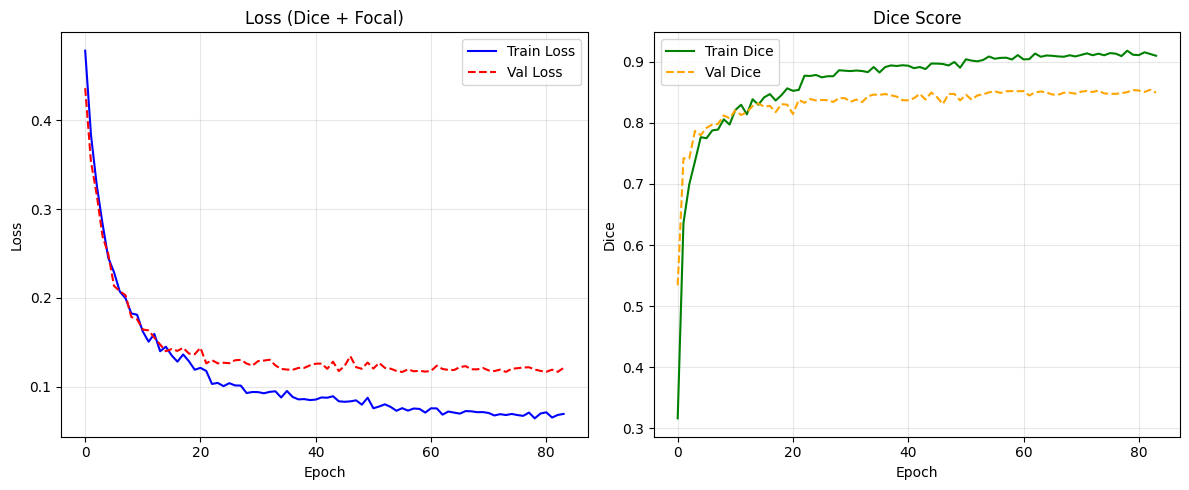

In [26]:
# ============================================================
# CELL EXTRA - GRAFICI ANDAMENTO
# ============================================================

plt.figure(figsize=(12, 5))

# 1. Grafico Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='red', linestyle='--')
plt.title('Loss (Dice + Focal)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Grafico Dice Score
plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Train Dice', color='green')
plt.plot(history['val_dice'], label='Val Dice', color='orange', linestyle='--')
plt.title('Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Qualitative Validation Samples
After training, we reload the best checkpoint and display representative ultrasound slices alongside ground-truth and predicted masks with per-case Dice scores.

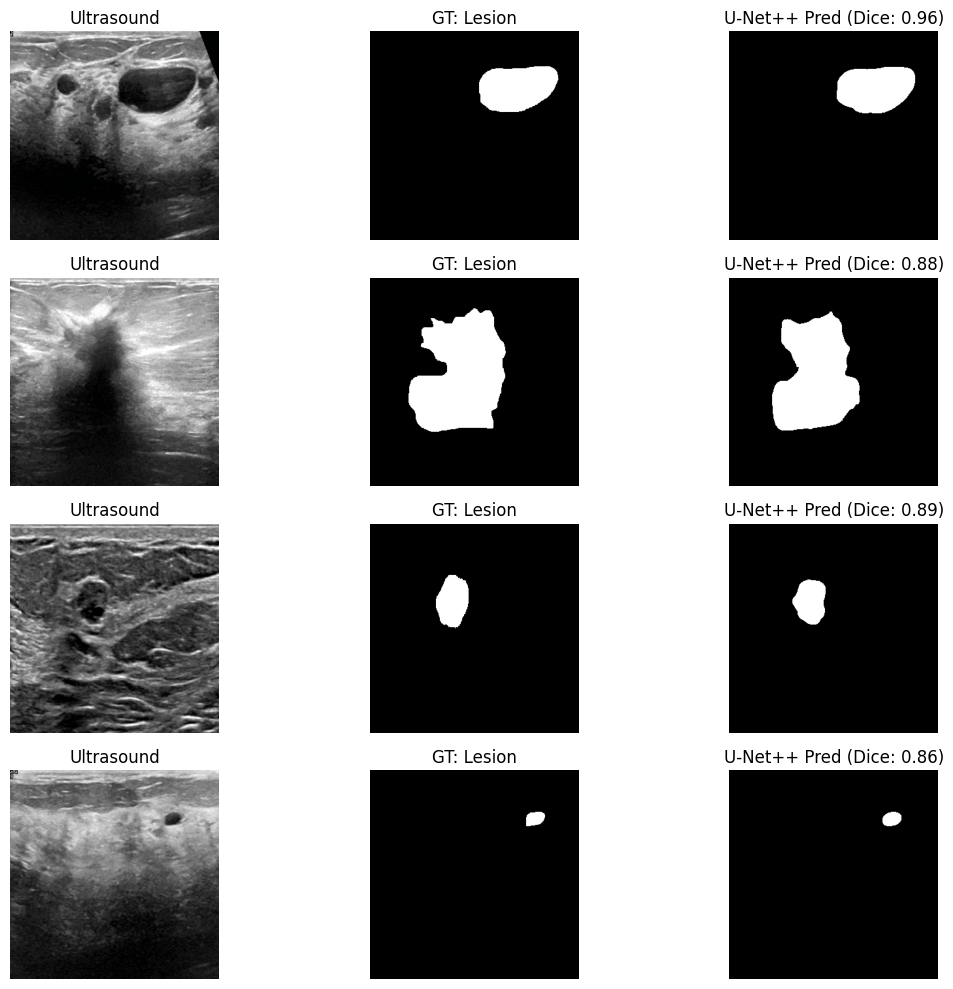

In [ ]:
# ============================================================
# CELL 5 - VISUALIZATION
# ============================================================
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    in_channels=3, 
    classes=1,
    decoder_channels=(256, 128, 64, 32, 16),
    deep_supervision=False  # Disabilitato per inference singola
)
model.load_state_dict(torch.load("best_unet_plusplus_b7.pt"))
model = model.to(device)
model.eval()

img, mask = next(iter(val_loader))
img, mask = img.to(device), mask.to(device)

with torch.no_grad():
    pred_logits = model(img)
    pred_mask = (torch.sigmoid(pred_logits) > 0.5).float()

plt.figure(figsize=(12, 10))
for i in range(4): 
    plt.subplot(4, 3, i*3 + 1)
    im_np = img[i].cpu().permute(1,2,0).numpy()
    im_np = im_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    plt.imshow(np.clip(im_np, 0, 1))
    plt.title("Ultrasound")
    plt.axis('off')
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(mask[i].cpu().squeeze(), cmap='gray')
    label_str = "Normal" if mask[i].sum() == 0 else "Lesion"
    plt.title(f"GT: {label_str}")
    plt.axis('off')
    
    plt.subplot(4, 3, i*3 + 3)
    score = dice_metric_smart(pred_logits[i:i+1], mask[i:i+1])
    plt.imshow(pred_mask[i].cpu().squeeze(), cmap='gray')
    plt.title(f"U-Net++ Pred (Dice: {score:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 📊 Comprehensive Segmentation Analysis for Academic Paper
The following cells provide detailed statistical analysis, publication-quality visualizations, and comprehensive metrics required for scientific reporting of the U-Net++ segmentation model performance.

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 1: COMPREHENSIVE METRICS COMPUTATION
# ============================================================

# Reload model for evaluation
model_eval_seg = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=None, 
    in_channels=3, 
    classes=1,
    decoder_channels=(256, 128, 64, 32, 16),
    deep_supervision=False
)
model_eval_seg.load_state_dict(torch.load("best_unet_plusplus_b7.pt"))
model_eval_seg = model_eval_seg.to(device)
model_eval_seg.eval()

# Collect predictions and compute multiple metrics
all_dice = []
all_iou = []
all_precision = []
all_recall = []
all_specificity = []
all_hausdorff = []
lesion_areas_gt = []
lesion_areas_pred = []

def compute_segmentation_metrics(pred, target, smooth=1e-7):
    """Compute comprehensive segmentation metrics."""
    pred_binary = (torch.sigmoid(pred) > 0.5).float()
    
    # Flatten for metric computation
    pred_flat = pred_binary.view(-1)
    target_flat = target.view(-1)
    
    # True positives, false positives, false negatives, true negatives
    tp = (pred_flat * target_flat).sum()
    fp = (pred_flat * (1 - target_flat)).sum()
    fn = ((1 - pred_flat) * target_flat).sum()
    tn = ((1 - pred_flat) * (1 - target_flat)).sum()
    
    # Dice coefficient
    dice = (2 * tp + smooth) / (2 * tp + fp + fn + smooth)
    
    # IoU (Jaccard Index)
    iou = (tp + smooth) / (tp + fp + fn + smooth)
    
    # Precision (Positive Predictive Value)
    precision = (tp + smooth) / (tp + fp + smooth)
    
    # Recall (Sensitivity)
    recall = (tp + smooth) / (tp + fn + smooth)
    
    # Specificity
    specificity = (tn + smooth) / (tn + fp + smooth)
    
    return {
        'dice': dice.item(),
        'iou': iou.item(),
        'precision': precision.item(),
        'recall': recall.item(),
        'specificity': specificity.item(),
        'tp': tp.item(),
        'fp': fp.item(),
        'fn': fn.item(),
        'tn': tn.item()
    }

print("Computing comprehensive segmentation metrics...")
with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(val_loader):
        images, masks = images.to(device), masks.to(device)
        outputs = model_eval_seg(images)
        
        for i in range(images.shape[0]):
            pred = outputs[i:i+1]
            target = masks[i:i+1]
            
            # Skip entirely empty ground truth masks (healthy cases)
            if target.sum() == 0:
                continue
            
            metrics = compute_segmentation_metrics(pred, target)
            all_dice.append(metrics['dice'])
            all_iou.append(metrics['iou'])
            all_precision.append(metrics['precision'])
            all_recall.append(metrics['recall'])
            all_specificity.append(metrics['specificity'])
            
            # Lesion areas
            pred_binary = (torch.sigmoid(pred) > 0.5).float()
            lesion_areas_gt.append(target.sum().item())
            lesion_areas_pred.append(pred_binary.sum().item())

print(f"Evaluated {len(all_dice)} lesion cases.")

# Convert to numpy
all_dice = np.array(all_dice)
all_iou = np.array(all_iou)
all_precision = np.array(all_precision)
all_recall = np.array(all_recall)
all_specificity = np.array(all_specificity)
lesion_areas_gt = np.array(lesion_areas_gt)
lesion_areas_pred = np.array(lesion_areas_pred)

# Print comprehensive statistics
print("\n" + "="*80)
print("COMPREHENSIVE SEGMENTATION METRICS SUMMARY")
print("="*80)
print(f"\n{'Metric':<20} {'Mean':<12} {'Std':<12} {'Median':<12} {'Min':<10} {'Max':<10}")
print("-"*80)
metrics_data = [
    ('Dice Score', all_dice),
    ('IoU (Jaccard)', all_iou),
    ('Precision', all_precision),
    ('Recall (Sens.)', all_recall),
    ('Specificity', all_specificity)
]
for name, data in metrics_data:
    print(f"{name:<20} {np.mean(data):<12.4f} {np.std(data):<12.4f} "
          f"{np.median(data):<12.4f} {np.min(data):<10.4f} {np.max(data):<10.4f}")
print("-"*80)

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 2: METRIC DISTRIBUTIONS
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Dice Score Distribution
ax1 = axes[0, 0]
ax1.hist(all_dice, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(all_dice), color='red', linestyle='--', lw=2, 
            label=f'Mean: {np.mean(all_dice):.4f}')
ax1.axvline(np.median(all_dice), color='green', linestyle='-.', lw=2, 
            label=f'Median: {np.median(all_dice):.4f}')
ax1.set_xlabel('Dice Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Dice Score Distribution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. IoU Distribution
ax2 = axes[0, 1]
ax2.hist(all_iou, bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
ax2.axvline(np.mean(all_iou), color='red', linestyle='--', lw=2, 
            label=f'Mean: {np.mean(all_iou):.4f}')
ax2.set_xlabel('IoU (Jaccard Index)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('IoU Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Precision vs Recall
ax3 = axes[0, 2]
ax3.scatter(all_recall, all_precision, alpha=0.6, c=all_dice, cmap='RdYlGn', s=50)
cbar = plt.colorbar(ax3.collections[0], ax=ax3)
cbar.set_label('Dice Score', fontsize=10)
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax3.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax3.set_ylabel('Precision', fontsize=12)
ax3.set_title('Precision vs Recall (colored by Dice)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1.05])
ax3.set_ylim([0, 1.05])

# 4. Boxplot of all metrics
ax4 = axes[1, 0]
metrics_boxplot = [all_dice, all_iou, all_precision, all_recall, all_specificity]
bp = ax4.boxplot(metrics_boxplot, labels=['Dice', 'IoU', 'Precision', 'Recall', 'Specificity'],
                 patch_artist=True)
colors_bp = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_ylabel('Score', fontsize=12)
ax4.set_title('Metric Distributions Comparison', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0, 1.05])

# 5. Lesion Area: Ground Truth vs Predicted
ax5 = axes[1, 1]
ax5.scatter(lesion_areas_gt, lesion_areas_pred, alpha=0.6, c='#3498db', s=50)
max_area = max(lesion_areas_gt.max(), lesion_areas_pred.max())
ax5.plot([0, max_area], [0, max_area], 'r--', lw=2, label='Perfect correlation')
ax5.set_xlabel('Ground Truth Lesion Area (pixels)', fontsize=12)
ax5.set_ylabel('Predicted Lesion Area (pixels)', fontsize=12)
ax5.set_title('Lesion Area: GT vs Predicted', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# Compute correlation
from scipy import stats
corr, p_value = stats.pearsonr(lesion_areas_gt, lesion_areas_pred)
ax5.annotate(f'r = {corr:.4f}\np < {p_value:.2e}', xy=(0.05, 0.85), xycoords='axes fraction',
             fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 6. Dice vs Lesion Size
ax6 = axes[1, 2]
ax6.scatter(lesion_areas_gt, all_dice, alpha=0.6, c='#9b59b6', s=50)
ax6.set_xlabel('Ground Truth Lesion Area (pixels)', fontsize=12)
ax6.set_ylabel('Dice Score', fontsize=12)
ax6.set_title('Dice Score vs Lesion Size', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(lesion_areas_gt, all_dice, 1)
p = np.poly1d(z)
x_trend = np.linspace(lesion_areas_gt.min(), lesion_areas_gt.max(), 100)
ax6.plot(x_trend, p(x_trend), 'r--', lw=2, label='Trend line')
ax6.legend(fontsize=10)

plt.tight_layout()
plt.savefig('segmentation_metric_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print correlation analysis
print("\n" + "="*70)
print("CORRELATION ANALYSIS")
print("="*70)
print(f"\nLesion Area (GT vs Predicted):")
print(f"  Pearson correlation: r = {corr:.4f}")
print(f"  P-value: {p_value:.2e}")
print(f"  Interpretation: {'Strong' if abs(corr) > 0.7 else 'Moderate' if abs(corr) > 0.5 else 'Weak'} correlation")

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 3: TRAINING DYNAMICS
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = range(1, len(history['train_loss']) + 1)

# 1. Loss curves with smoothing
ax1 = axes[0, 0]

def smooth(y, factor=0.9):
    smoothed = []
    for i, val in enumerate(y):
        if i == 0:
            smoothed.append(val)
        else:
            smoothed.append(factor * smoothed[-1] + (1 - factor) * val)
    return smoothed

ax1.plot(epochs, history['train_loss'], alpha=0.3, color='blue')
ax1.plot(epochs, history['val_loss'], alpha=0.3, color='red')
ax1.plot(epochs, smooth(history['train_loss']), color='blue', lw=2.5, label='Train Loss (smoothed)')
ax1.plot(epochs, smooth(history['val_loss']), color='red', lw=2.5, label='Val Loss (smoothed)')
best_epoch_loss = np.argmin(history['val_loss']) + 1
ax1.axvline(x=best_epoch_loss, color='green', linestyle='--', 
            label=f'Best Val Loss: epoch {best_epoch_loss}')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (Dice + Focal + Lovasz)', fontsize=12)
ax1.set_title('Segmentation Training Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Dice score curves
ax2 = axes[0, 1]
ax2.plot(epochs, history['train_dice'], alpha=0.3, color='blue')
ax2.plot(epochs, history['val_dice'], alpha=0.3, color='red')
ax2.plot(epochs, smooth(history['train_dice']), color='blue', lw=2.5, label='Train Dice (smoothed)')
ax2.plot(epochs, smooth(history['val_dice']), color='red', lw=2.5, label='Val Dice (smoothed)')
best_epoch_dice = np.argmax(history['val_dice']) + 1
best_dice = max(history['val_dice'])
ax2.axhline(y=best_dice, color='green', linestyle='--', alpha=0.7,
            label=f'Best Val Dice: {best_dice:.4f}')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Dice Score', fontsize=12)
ax2.set_title('Segmentation Dice Score', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Overfitting gap analysis
ax3 = axes[1, 0]
dice_gap = np.array(history['train_dice']) - np.array(history['val_dice'])
ax3.fill_between(epochs, 0, dice_gap, where=(dice_gap > 0), 
                 alpha=0.5, color='red', label='Overfitting region')
ax3.fill_between(epochs, 0, dice_gap, where=(dice_gap <= 0), 
                 alpha=0.5, color='green', label='Underfitting region')
ax3.axhline(y=0, color='black', linestyle='-', lw=1)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('Train - Val Dice Gap', fontsize=12)
ax3.set_title('Generalization Gap (Dice)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Learning progress (cumulative best)
ax4 = axes[1, 1]
cumulative_best_dice = np.maximum.accumulate(history['val_dice'])
ax4.plot(epochs, history['val_dice'], alpha=0.5, color='blue', label='Validation Dice')
ax4.plot(epochs, cumulative_best_dice, color='green', lw=2.5, label='Best So Far')
ax4.fill_between(epochs, 0, cumulative_best_dice, alpha=0.2, color='green')
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Dice Score', fontsize=12)
ax4.set_title('Learning Progress (Best Dice Achieved)', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('segmentation_training_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()

# Print training statistics
print("\n" + "="*70)
print("SEGMENTATION TRAINING SUMMARY")
print("="*70)
print(f"\n{'Metric':<40} {'Value':<15}")
print("-"*55)
print(f"{'Total epochs trained':<40} {len(history['train_loss']):<15}")
print(f"{'Best validation loss epoch':<40} {best_epoch_loss:<15}")
print(f"{'Best validation Dice epoch':<40} {best_epoch_dice:<15}")
print(f"{'Final training loss':<40} {history['train_loss'][-1]:<15.4f}")
print(f"{'Final validation loss':<40} {history['val_loss'][-1]:<15.4f}")
print(f"{'Best validation loss':<40} {min(history['val_loss']):<15.4f}")
print(f"{'Final train Dice':<40} {history['train_dice'][-1]:<15.4f}")
print(f"{'Final validation Dice':<40} {history['val_dice'][-1]:<15.4f}")
print(f"{'Best validation Dice':<40} {max(history['val_dice']):<15.4f}")
print(f"{'Average Dice gap (last 10 epochs)':<40} {np.mean(dice_gap[-10:]):<15.4f}")

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 4: QUALITATIVE ANALYSIS
# ============================================================

# Get best, worst, and median cases
dice_sorted_idx = np.argsort(all_dice)
best_indices = dice_sorted_idx[-3:]  # Top 3
worst_indices = dice_sorted_idx[:3]   # Bottom 3
median_idx = len(all_dice) // 2
median_indices = dice_sorted_idx[median_idx-1:median_idx+2]  # Around median

# Collect samples for visualization
sample_images = []
sample_masks_gt = []
sample_masks_pred = []
sample_dice = []
sample_types = []

current_idx = 0
with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model_eval_seg(images)
        
        for i in range(images.shape[0]):
            if masks[i].sum() == 0:
                continue
            
            if current_idx in best_indices:
                sample_images.append(images[i].cpu())
                sample_masks_gt.append(masks[i].cpu())
                pred = (torch.sigmoid(outputs[i]) > 0.5).float()
                sample_masks_pred.append(pred.cpu())
                sample_dice.append(all_dice[current_idx])
                sample_types.append('Best')
            elif current_idx in worst_indices:
                sample_images.append(images[i].cpu())
                sample_masks_gt.append(masks[i].cpu())
                pred = (torch.sigmoid(outputs[i]) > 0.5).float()
                sample_masks_pred.append(pred.cpu())
                sample_dice.append(all_dice[current_idx])
                sample_types.append('Worst')
            elif current_idx in median_indices:
                sample_images.append(images[i].cpu())
                sample_masks_gt.append(masks[i].cpu())
                pred = (torch.sigmoid(outputs[i]) > 0.5).float()
                sample_masks_pred.append(pred.cpu())
                sample_dice.append(all_dice[current_idx])
                sample_types.append('Median')
            
            current_idx += 1

# Plot best, median, and worst cases
fig, axes = plt.subplots(3, 9, figsize=(24, 10))

# Denormalization
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for row, case_type in enumerate(['Best', 'Median', 'Worst']):
    type_indices = [i for i, t in enumerate(sample_types) if t == case_type][:3]
    
    for col, idx in enumerate(type_indices):
        img = sample_images[idx].permute(1, 2, 0).numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        gt = sample_masks_gt[idx].squeeze().numpy()
        pred = sample_masks_pred[idx].squeeze().numpy()
        
        # Original image
        axes[row, col*3].imshow(img)
        axes[row, col*3].set_title(f'{case_type} Case {col+1}', fontsize=11, fontweight='bold')
        axes[row, col*3].axis('off')
        
        # Ground truth
        axes[row, col*3+1].imshow(gt, cmap='gray')
        axes[row, col*3+1].set_title('Ground Truth', fontsize=10)
        axes[row, col*3+1].axis('off')
        
        # Prediction with Dice
        axes[row, col*3+2].imshow(pred, cmap='gray')
        axes[row, col*3+2].set_title(f'Prediction (Dice: {sample_dice[idx]:.3f})', fontsize=10)
        axes[row, col*3+2].axis('off')

plt.suptitle('Segmentation Quality Analysis: Best, Median, and Worst Cases', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('segmentation_qualitative_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print qualitative summary
print("\n" + "="*70)
print("QUALITATIVE ANALYSIS SUMMARY")
print("="*70)
print(f"\nBest performing cases (Dice):")
for i, idx in enumerate(best_indices[::-1]):
    print(f"  {i+1}. Dice = {all_dice[idx]:.4f}")

print(f"\nWorst performing cases (Dice):")
for i, idx in enumerate(worst_indices):
    print(f"  {i+1}. Dice = {all_dice[idx]:.4f}")

print(f"\nMedian case Dice: {np.median(all_dice):.4f}")

In [ ]:
# ============================================================
# SEGMENTATION ANALYSIS - PART 5: ERROR ANALYSIS & PERFORMANCE STRATIFICATION
# ============================================================

# Stratify by lesion size
size_quartiles = np.percentile(lesion_areas_gt, [25, 50, 75])
small_mask = lesion_areas_gt <= size_quartiles[0]
medium_mask = (lesion_areas_gt > size_quartiles[0]) & (lesion_areas_gt <= size_quartiles[2])
large_mask = lesion_areas_gt > size_quartiles[2]

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Dice by lesion size category
ax1 = axes[0, 0]
size_categories = ['Small\n(Q1)', 'Medium\n(Q2-Q3)', 'Large\n(Q4)']
dice_by_size = [all_dice[small_mask], all_dice[medium_mask], all_dice[large_mask]]
bp1 = ax1.boxplot(dice_by_size, labels=size_categories, patch_artist=True)
colors_size = ['#e74c3c', '#f39c12', '#2ecc71']
for patch, color in zip(bp1['boxes'], colors_size):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Dice Score', fontsize=12)
ax1.set_xlabel('Lesion Size Category', fontsize=12)
ax1.set_title('Performance by Lesion Size', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add mean values as text
for i, data in enumerate(dice_by_size):
    ax1.annotate(f'μ={np.mean(data):.3f}', xy=(i+1, np.mean(data)), 
                 xytext=(i+1.2, np.mean(data)), fontsize=10)

# 2. Error distribution (GT area - Pred area)
ax2 = axes[0, 1]
area_error = lesion_areas_pred - lesion_areas_gt
ax2.hist(area_error, bins=40, color='#9b59b6', edgecolor='black', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', lw=2, label='No error')
ax2.axvline(np.mean(area_error), color='green', linestyle='-.', lw=2, 
            label=f'Mean: {np.mean(area_error):.1f}')
ax2.set_xlabel('Area Error (Pred - GT) in pixels', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('Lesion Area Prediction Error Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Under/Over segmentation analysis
ax3 = axes[1, 0]
under_seg = area_error < 0
over_seg = area_error > 0
categories = ['Under-segmentation', 'Over-segmentation', 'Exact']
counts = [under_seg.sum(), over_seg.sum(), len(area_error) - under_seg.sum() - over_seg.sum()]
colors_seg = ['#e74c3c', '#3498db', '#2ecc71']
bars = ax3.bar(categories, counts, color=colors_seg, edgecolor='black', alpha=0.7)
ax3.set_ylabel('Number of Cases', fontsize=12)
ax3.set_title('Segmentation Bias Analysis', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

# Add percentages
for bar, count in zip(bars, counts):
    ax3.annotate(f'{count/len(area_error)*100:.1f}%', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Dice score threshold analysis
ax4 = axes[1, 1]
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
above_threshold = [np.mean(all_dice >= t) * 100 for t in thresholds]
bars = ax4.bar([f'≥{t}' for t in thresholds], above_threshold, 
               color=['#e74c3c' if v < 50 else '#f39c12' if v < 75 else '#2ecc71' for v in above_threshold],
               edgecolor='black', alpha=0.7)
ax4.set_xlabel('Dice Threshold', fontsize=12)
ax4.set_ylabel('Percentage of Cases (%)', fontsize=12)
ax4.set_title('Cases Achieving Dice Threshold', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0, 100])

# Add percentages on bars
for bar, pct in zip(bars, above_threshold):
    ax4.annotate(f'{pct:.1f}%', 
                 xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('segmentation_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print error analysis
print("\n" + "="*70)
print("ERROR ANALYSIS SUMMARY")
print("="*70)
print(f"\nPerformance by Lesion Size:")
print(f"  Small lesions (Q1): Mean Dice = {np.mean(all_dice[small_mask]):.4f} (n={small_mask.sum()})")
print(f"  Medium lesions (Q2-Q3): Mean Dice = {np.mean(all_dice[medium_mask]):.4f} (n={medium_mask.sum()})")
print(f"  Large lesions (Q4): Mean Dice = {np.mean(all_dice[large_mask]):.4f} (n={large_mask.sum()})")

print(f"\nSegmentation Bias:")
print(f"  Under-segmentation cases: {under_seg.sum()} ({under_seg.sum()/len(area_error)*100:.1f}%)")
print(f"  Over-segmentation cases: {over_seg.sum()} ({over_seg.sum()/len(area_error)*100:.1f}%)")
print(f"  Mean area error: {np.mean(area_error):.1f} pixels")
print(f"  Std area error: {np.std(area_error):.1f} pixels")

print(f"\nCases Meeting Clinical Thresholds:")
for t in thresholds:
    print(f"  Dice ≥ {t}: {np.mean(all_dice >= t)*100:.1f}%")

## 1c. Unified Classification and Segmentation Pipeline

This final section composes the pretrained classifier and segmenter into an end-to-end pipeline, evaluating both decisions and masks on the validation partition.

In [ ]:
# ============================================================
# FINAL PIPELINE (CUSTOM CLASSIFIER HEAD + MANET)
# ============================================================
# Ensure the segmentation models library is available even if this block runs independently
if 'smp' not in globals():
    import segmentation_models_pytorch as smp

if 'models' not in globals():
    from torchvision import models

# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EXCEL_PATH = "/kaggle/input/tumor-segmentation-ai/training_metadata.xlsx"
IMAGES_ROOT = "/kaggle/input/tumor-segmentation-ai/training_images/training_images"

# Weight paths (replace with local paths if models are stored elsewhere)
PATH_CLF = "/kaggle/working/best_model_b7_dual.pt"
PATH_SEG = "/kaggle/working/best_unet_plusplus_b7.pt"

# Resolutions matching the respective training regimes
IMG_SIZE_CLF = 300
IMG_SIZE_SEG = 320
NUM_CLASSES = 3
SEED = 42

# Mapping used for reporting
id2class = {0: "Benign", 1: "Malignant", 2: "Normal"}

print(f"Pipeline ready on {DEVICE}.")

Pipeline ready on cuda.


**Pipeline Outline.** The concluding cells load the pretrained classifier and segmenter, run coordinated inference on the validation fold, and summarise performance with classification confusion matrices and Dice-based lesion metrics.

In [ ]:
# ============================================================
# CELL 2 - ARCHITECTURES AND WEIGHT LOADING
# ============================================================

# --- 1. Classifier (custom head) ---
def get_classifier():
    # Reinstantiate EfficientNet-B7 without pretrained weights; the checkpoint will be loaded manually
    model = models.efficientnet_b7(weights=None)

    # Rebuild the exact head used during training
    in_features = model.classifier[1].in_features

    model.classifier = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Linear(in_features, 512),
        nn.ReLU(),
        nn.Dropout(p=0.5, inplace=False),
        nn.Linear(512, NUM_CLASSES)
    )
    return model

# --- 2. Segmenter (U-Net++) ---
def get_segmentor():
    # Architettura SOTA: U-Net++ (UnetPlusPlus)
    # Deep supervision DISABILITATA per inferenza (output singolo)
    model = smp.UnetPlusPlus(
        encoder_name=ENCODER,
        encoder_weights=None,  # Carichiamo i pesi dal checkpoint
        in_channels=3,
        classes=CLASSES,
        activation=ACTIVATION,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_attention_type=None,
        deep_supervision=False  # <-- Disabilitato per inference
    )
    return model

# --- 3. Robust weight loader ---
def load_weights(model, path):
    if not os.path.exists(path):
        print(f"Critical error: file not found -> {path}")
        return model

    print(f"Loading weights from: {path}")
    state_dict = torch.load(path, map_location=DEVICE)

    # Clean up potential 'module.' prefixes introduced by DataParallel
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace("module.", "")
        new_state_dict[name] = v

    try:
        model.load_state_dict(new_state_dict)
        print("   Weights loaded successfully.")
    except Exception as e:
        print(f"   Weight loading failed: {e}")

    return model.to(DEVICE).eval()

# --- Initialisation ---
print("--- Model setup ---")

clf_model = get_classifier()
clf_model = load_weights(clf_model, PATH_CLF)

seg_model = get_segmentor()
seg_model = load_weights(seg_model, PATH_SEG)

print("\nClassifier and segmenter ready for the combined pipeline.")

--- Model setup ---
Loading weights from: /kaggle/working/best_model_b7_dual.pt
   Weights loaded successfully.
Loading weights from: /kaggle/working/best_unet_plusplus_b7.pt
   Weights loaded successfully.

Classifier and segmenter ready for the combined pipeline.


### Unified Dataset Wrapper
This dataset prepares paired classifier and segmenter inputs, ensuring consistent resizing and normalisation while retaining the original image for visual reporting.

In [ ]:
# ============================================================
# CELL 3 - PIPELINE DATASET
# ============================================================
class PipelineDataset(Dataset):
    def __init__(self, df, root):
        self.df = df.reset_index(drop=True)
        self.root = root

        # Transform for the classifier (600x600)
        self.transform_clf = T.Compose([
            T.Resize((IMG_SIZE_CLF, IMG_SIZE_CLF)),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # Transform for the segmenter 
        self.transform_seg = A.Compose([
            A.Resize(IMG_SIZE_SEG, IMG_SIZE_SEG),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Paths
        img_name = str(self.df.loc[idx, "US"])
        mask_name = str(self.df.loc[idx, "MASK"])
        label = int(self.df.loc[idx, "LABEL"])

        # Load image and mask
        img_path = os.path.join(self.root, img_name)
        pil_img = Image.open(img_path).convert("RGB")
        np_img = np.array(pil_img)

        try:
            mask_path = os.path.join(self.root, mask_name)
            mask = np.array(Image.open(mask_path).convert("L"))
            mask = np.where(mask > 0, 1.0, 0.0).astype(np.float32)
        except Exception:
            # Use a blank mask when the file is missing (e.g., normal cases)
            mask = np.zeros((np_img.shape[0], np_img.shape[1]), dtype=np.float32)

        # Input for the classifier
        input_clf = self.transform_clf(pil_img)

        # Input for the segmenter (mask resized accordingly)
        aug = self.transform_seg(image=np_img, mask=mask)
        input_seg = aug['image']
        target_mask = aug['mask'].unsqueeze(0)

        return input_clf, input_seg, label, target_mask, np_img

# Create the validation set (same seed as training to maintain alignment)
from sklearn.model_selection import train_test_split
df = pd.read_excel(EXCEL_PATH).dropna(subset=["US", "LABEL"])
_, val_df = train_test_split(df, stratify=df["LABEL"], test_size=0.2, random_state=SEED)

test_loader = DataLoader(PipelineDataset(val_df, IMAGES_ROOT), batch_size=1, shuffle=False)
print(f"Validation dataset prepared: {len(val_df)} images.")

Validation dataset prepared: 301 images.


### Joint Evaluation Metrics
The pipeline metrics differentiate overall balanced accuracy from lesion-oriented Dice scores, highlighting how classification performance impacts downstream segmentation quality.

In [31]:
# ============================================================
# CELL 4 - ESECUZIONE PIPELINE (CLASSIFICATION -> SEGMENTATION)
# ============================================================

# Funzione Dice Smart (Gestisce correttemente i doppi vuoti)
def dice_metric_smart(pred, target):
    pred = (torch.sigmoid(pred) > 0.5).float()
    
    # Se entrambi vuoti (Paziente Sano classificato correttamente come Sano)
    # Il Dice è 1.0 (Perfetto)
    if pred.sum() == 0 and target.sum() == 0:
        return torch.tensor(1.0).to(DEVICE)
    
    intersection = (pred * target).sum()
    # Aggiungiamo epsilon per evitare divisioni per zero
    return (2. * intersection) / (pred.sum() + target.sum() + 1e-7)

results = {
    "true_labels": [], "pred_labels": [], 
    "dice_scores": [], "images": [], "pred_masks": [], "true_masks": []
}

print("🚀 Esecuzione Pipeline: Classificazione (Gatekeeper) -> Segmentazione...")

with torch.no_grad():
    for i, (in_clf, in_seg, label_true, mask_true, raw_img) in enumerate(test_loader):
        in_clf, in_seg = in_clf.to(DEVICE), in_seg.to(DEVICE)
        mask_true = mask_true.to(DEVICE)
        
        # --- STEP 1: CLASSIFICAZIONE ---
        # Usiamo TTA (Test Time Augmentation) per rendere il classificatore più sicuro
        # visto che da lui dipende tutto il resto.
        logits = clf_model(in_clf)
        logits_flip = clf_model(torch.flip(in_clf, [3]))
        avg_prob = (torch.softmax(logits, 1) + torch.softmax(logits_flip, 1)) / 2.0
        
        pred_class = avg_prob.argmax(1).item() # 0, 1, o 2
        
        results["true_labels"].append(label_true.item())
        results["pred_labels"].append(pred_class)
        
        # --- STEP 2: LOGICA CONDIZIONALE ---
        final_mask = None
        
        if pred_class == 2: # NORMAL (Sano)
            # Se il classificatore dice Sano, NON segmentiamo.
            # Restituiamo una maschera nera.
            final_mask = torch.zeros_like(mask_true)
            
        else: # BENIGN (0) o MALIGNANT (1)
            # Il classificatore ha trovato una lesione -> Attiviamo la U-Net
            seg_logits = seg_model(in_seg)
            final_mask = (torch.sigmoid(seg_logits) > 0.5).float()
        
        # --- STEP 3: VALUTAZIONE ---
        # Calcoliamo il Dice. Se era Normal, confrontiamo Nero vs Ground Truth.
        dice = dice_metric_smart(final_mask, mask_true).item()
        results["dice_scores"].append(dice)
        
        # Salvataggio esempi per visualizzazione
        if i < 10:
            results["images"].append(raw_img.squeeze(0).numpy())
            results["pred_masks"].append(final_mask.cpu().squeeze().numpy())
            results["true_masks"].append(mask_true.cpu().squeeze().numpy())

print("Pipeline completata.")

🚀 Esecuzione Pipeline: Classificazione (Gatekeeper) -> Segmentazione...
Pipeline completata.



=== RESULTS: TASK 1a (CLASSIFICATION) ===
Balanced Accuracy: 0.8526
              precision    recall  f1-score   support

      Benign       0.86      0.85      0.86       136
   Malignant       0.88      0.78      0.83        73
      Normal       0.84      0.92      0.88        92

    accuracy                           0.86       301
   macro avg       0.86      0.85      0.85       301
weighted avg       0.86      0.86      0.86       301



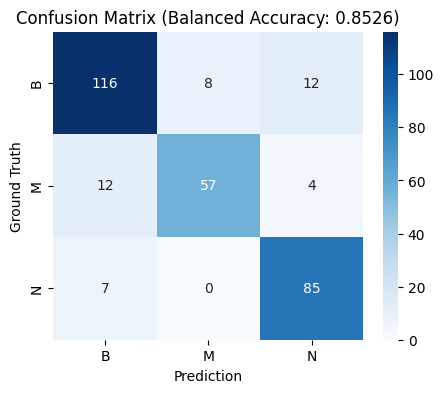


=== RESULTS: TASK 1b (SEGMENTATION) ===
1. Global Dice Score (complete pipeline):        0.8073
2. Lesion Dice Score (effectiveness on patients): 0.7559
3. Conditional Dice (segmenter quality when triggered): 0.8186

Pipeline error analysis:
Lesions missed by the classifier (false negatives): 16 of 209 total lesion cases.


In [32]:
# ============================================================
# CELL 5 - COMPREHENSIVE REPORTING
# ============================================================

# --- 1. Classification metrics ---
print("\n=== RESULTS: TASK 1a (CLASSIFICATION) ===")
# Balanced accuracy
bal_acc = balanced_accuracy_score(results["true_labels"], results["pred_labels"])
print(f"Balanced Accuracy: {bal_acc:.4f}")

print(classification_report(results["true_labels"], results["pred_labels"],
                            target_names=["Benign", "Malignant", "Normal"]))

# Confusion matrix
cm = confusion_matrix(results["true_labels"], results["pred_labels"])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["B", "M", "N"], yticklabels=["B", "M", "N"])
plt.title(f"Confusion Matrix (Balanced Accuracy: {bal_acc:.4f})")
plt.ylabel("Ground Truth")
plt.xlabel("Prediction")
plt.show()

# --- 2. Segmentation metrics ---
df_res = pd.DataFrame({
    "True": results["true_labels"],
    "Pred": results["pred_labels"],
    "Dice": results["dice_scores"]
})

# A. Global Dice (mean across the entire dataset, including healthy cases)
dice_global = df_res["Dice"].mean()

# B. Lesion Dice (mean only for cases that are truly tumorous)
# Includes zeros when the classifier misses the lesion
lesion_mask = df_res["True"] != 2
dice_lesion = df_res[lesion_mask]["Dice"].mean()

# C. Conditional Dice (mean only when both classifier and segmenter predict a lesion)
dice_tp = df_res[(df_res["True"] != 2) & (df_res["Pred"] != 2)]["Dice"].mean()

print("\n=== RESULTS: TASK 1b (SEGMENTATION) ===")
print(f"1. Global Dice Score (complete pipeline):        {dice_global:.4f}")
print(f"2. Lesion Dice Score (effectiveness on patients): {dice_lesion:.4f}")
print(f"3. Conditional Dice (segmenter quality when triggered): {dice_tp:.4f}")

# Error analysis
missed = df_res[(df_res["True"] != 2) & (df_res["Pred"] == 2)]
print("\nPipeline error analysis:")
print(f"Lesions missed by the classifier (false negatives): {len(missed)} of {lesion_mask.sum()} total lesion cases.")

### Visual Inspection of Pipeline Outputs
Finally, we compare ground-truth and predicted masks for exemplar cases, colour-coding titles by classification correctness and annotating Dice scores for transparency.

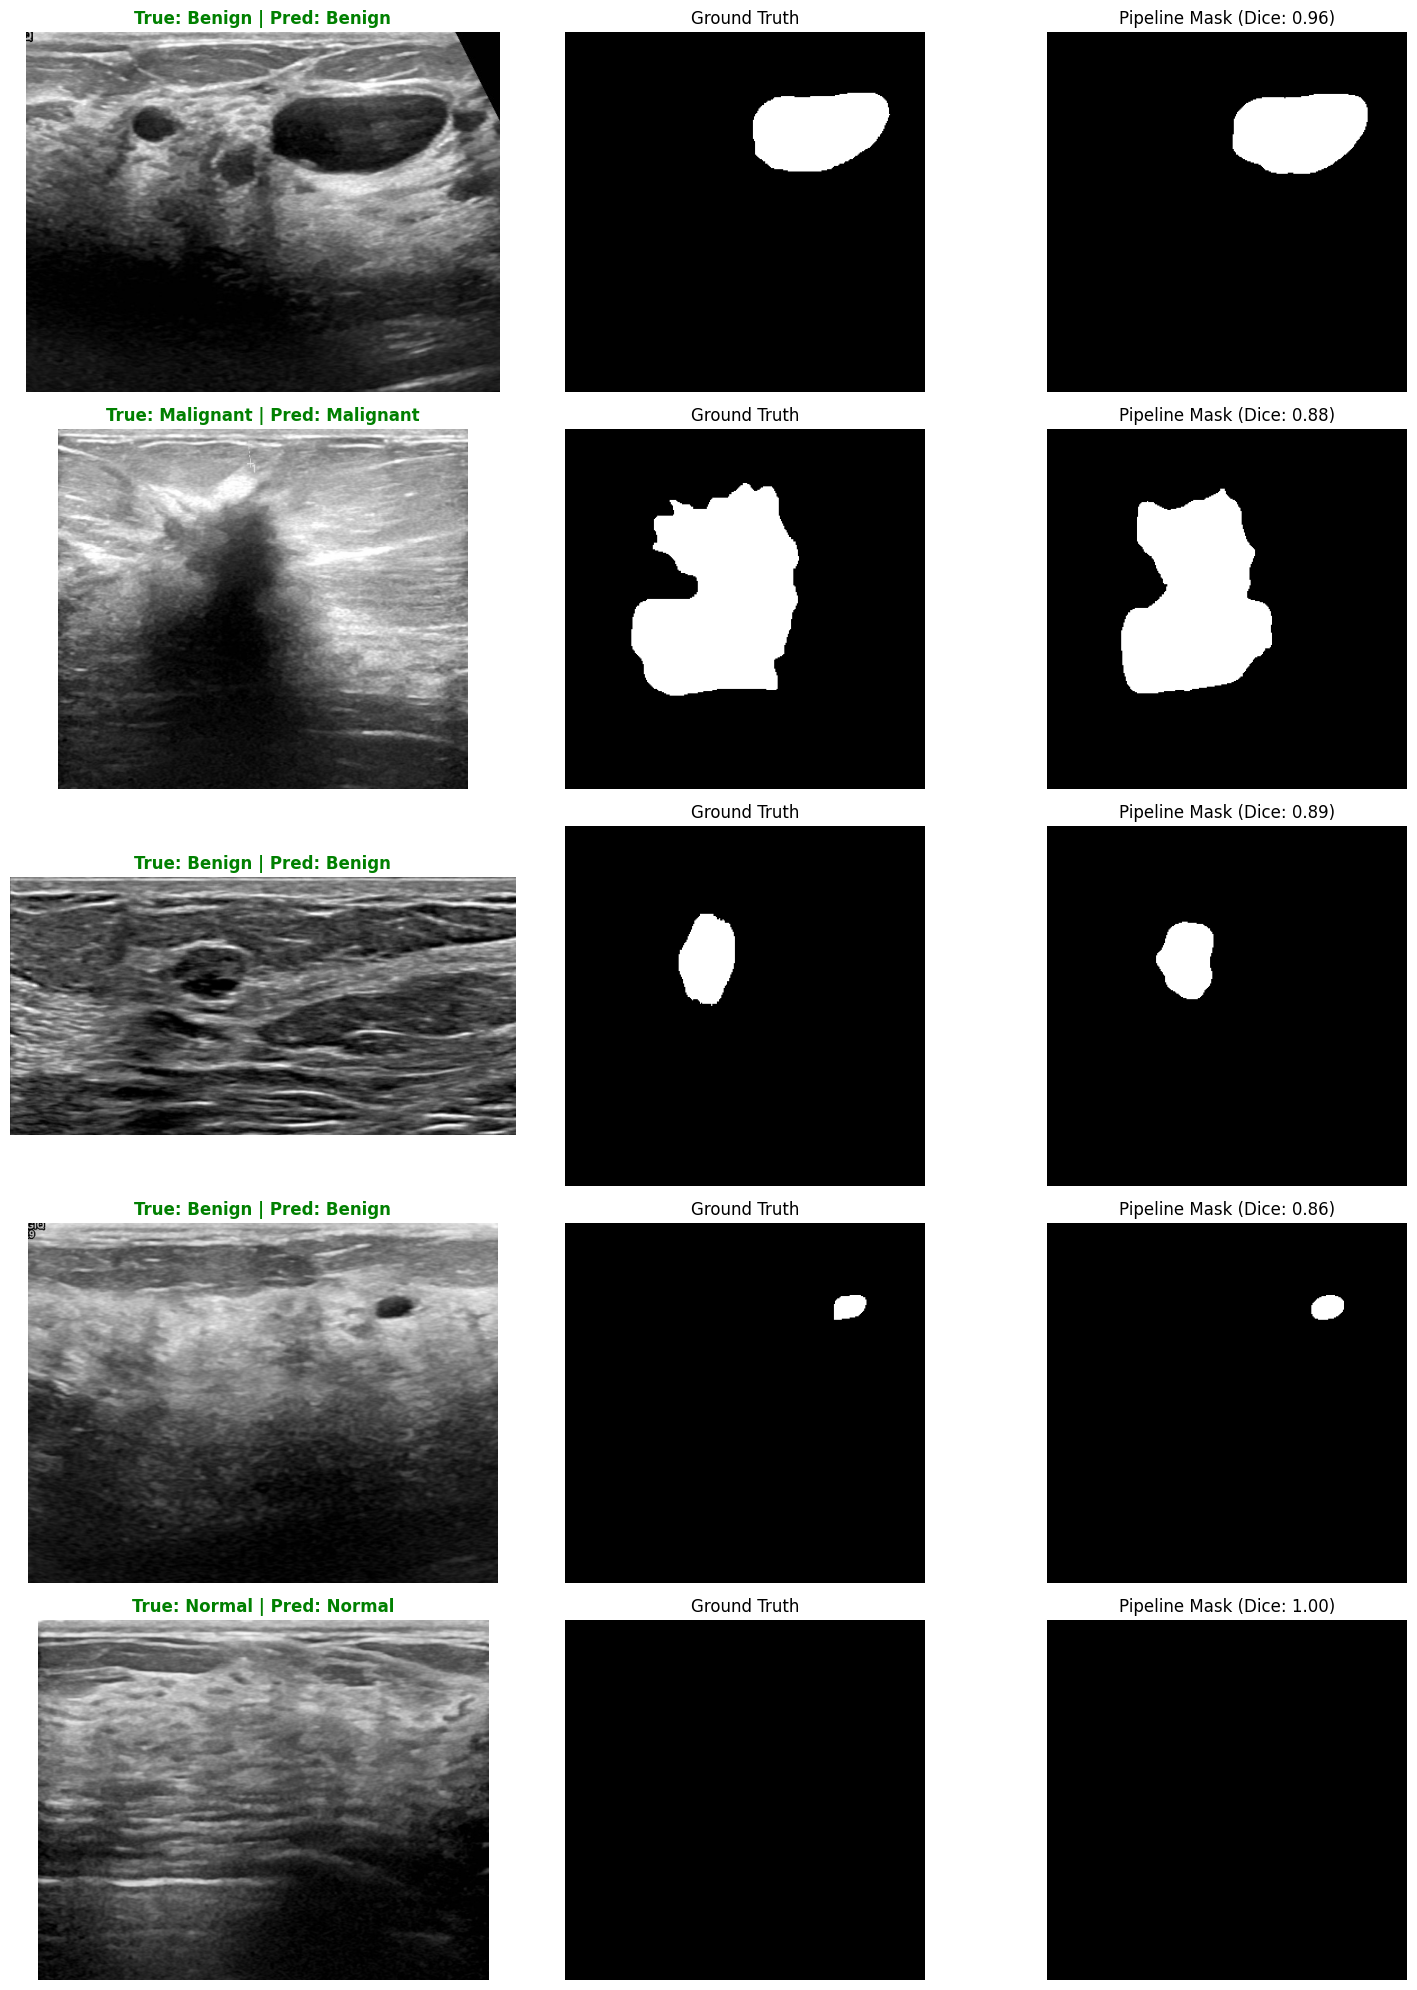

In [33]:
# ============================================================
# CELL 6 - VISUALISATION
# ============================================================
num_show = 5
plt.figure(figsize=(15, 4 * num_show))

for i in range(num_show):
    img = results["images"][i]
    true_m = results["true_masks"][i]
    pred_m = results["pred_masks"][i]
    t_lbl = id2class[results["true_labels"][i]]
    p_lbl = id2class[results["pred_labels"][i]]
    dice = results["dice_scores"][i]

    # Title colour: green for correct classifications, red for errors
    col = 'green' if t_lbl == p_lbl else 'red'

    plt.subplot(num_show, 3, i * 3 + 1)
    plt.imshow(img)
    plt.title(f"True: {t_lbl} | Pred: {p_lbl}", color=col, fontweight='bold')
    plt.axis('off')

    plt.subplot(num_show, 3, i * 3 + 2)
    plt.imshow(true_m, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(num_show, 3, i * 3 + 3)
    plt.imshow(pred_m, cmap='gray')
    plt.title(f"Pipeline Mask (Dice: {dice:.2f})")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 📊 Comprehensive Pipeline Analysis for Academic Paper
The following cells provide detailed statistical analysis of the combined classification-segmentation pipeline performance, including end-to-end metrics, error propagation analysis, and clinical utility assessment.

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 1: END-TO-END PERFORMANCE METRICS
# ============================================================

# Convert results to numpy arrays for analysis
y_true_pipeline = np.array(results["true_labels"])
y_pred_pipeline = np.array(results["pred_labels"])
dice_scores_pipeline = np.array(results["dice_scores"])

# Classification metrics in pipeline context
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, precision_score,
                            recall_score, f1_score, cohen_kappa_score, matthews_corrcoef,
                            confusion_matrix, classification_report)

# Overall classification metrics
pipeline_acc = accuracy_score(y_true_pipeline, y_pred_pipeline)
pipeline_bal_acc = balanced_accuracy_score(y_true_pipeline, y_pred_pipeline)
pipeline_macro_f1 = f1_score(y_true_pipeline, y_pred_pipeline, average='macro')
pipeline_weighted_f1 = f1_score(y_true_pipeline, y_pred_pipeline, average='weighted')
pipeline_kappa = cohen_kappa_score(y_true_pipeline, y_pred_pipeline)
pipeline_mcc = matthews_corrcoef(y_true_pipeline, y_pred_pipeline)

# Segmentation metrics for pipeline
global_dice = dice_scores_pipeline.mean()
lesion_mask_pipeline = y_true_pipeline != 2
lesion_dice = dice_scores_pipeline[lesion_mask_pipeline].mean()
conditional_dice = dice_scores_pipeline[(y_true_pipeline != 2) & (y_pred_pipeline != 2)].mean()

# Combined pipeline score (harmonic mean of classification and segmentation)
pipeline_combined_score = 2 * pipeline_bal_acc * lesion_dice / (pipeline_bal_acc + lesion_dice + 1e-7)

# Print comprehensive summary
print("\n" + "="*80)
print("END-TO-END PIPELINE PERFORMANCE SUMMARY")
print("="*80)

print("\n" + "-"*40)
print("CLASSIFICATION COMPONENT")
print("-"*40)
print(f"{'Metric':<30} {'Value':<15}")
print("-"*45)
print(f"{'Overall Accuracy':<30} {pipeline_acc:<15.4f}")
print(f"{'Balanced Accuracy':<30} {pipeline_bal_acc:<15.4f}")
print(f"{'Macro F1-Score':<30} {pipeline_macro_f1:<15.4f}")
print(f"{'Weighted F1-Score':<30} {pipeline_weighted_f1:<15.4f}")
cohens_kappa_label = "Cohen's Kappa"
print(f"{cohens_kappa_label:<30} {pipeline_kappa:<15.4f}")
print(f"{'Matthews Corr. Coef.':<30} {pipeline_mcc:<15.4f}")

print("\n" + "-"*40)
print("SEGMENTATION COMPONENT")
print("-"*40)
print(f"{'Metric':<30} {'Value':<15}")
print("-"*45)
print(f"{'Global Dice (all cases)':<30} {global_dice:<15.4f}")
print(f"{'Lesion Dice (tumorous only)':<30} {lesion_dice:<15.4f}")
print(f"{'Conditional Dice (TP cases)':<30} {conditional_dice:<15.4f}")

print("\n" + "-"*40)
print("COMBINED PIPELINE METRICS")
print("-"*40)
print(f"{'Pipeline Combined Score':<30} {pipeline_combined_score:<15.4f}")
print(f"(Harmonic mean of Balanced Accuracy and Lesion Dice)")

# Per-class detailed report
print("\n" + "="*80)
print("PER-CLASS CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_true_pipeline, y_pred_pipeline,
                           target_names=["Benign", "Malignant", "Normal"],
                           digits=4))

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 2: ERROR PROPAGATION ANALYSIS
# ============================================================

# Analyze how classification errors affect segmentation
cm_pipeline = confusion_matrix(y_true_pipeline, y_pred_pipeline)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# 1. Enhanced confusion matrix with error analysis
ax1 = axes[0, 0]
cm_norm = cm_pipeline.astype('float') / cm_pipeline.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='RdYlGn', ax=ax1,
            xticklabels=["Benign", "Malignant", "Normal"],
            yticklabels=["Benign", "Malignant", "Normal"],
            annot_kws={'size': 12, 'weight': 'bold'},
            vmin=0, vmax=100)
ax1.set_title('Classification Confusion Matrix (%)', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# 2. Dice score by classification outcome
ax2 = axes[0, 1]
correct_clf = y_true_pipeline == y_pred_pipeline
incorrect_clf = ~correct_clf

# Only consider lesion cases for this analysis
lesion_correct = correct_clf & lesion_mask_pipeline
lesion_incorrect = incorrect_clf & lesion_mask_pipeline

dice_correct = dice_scores_pipeline[lesion_correct]
dice_incorrect = dice_scores_pipeline[lesion_incorrect]

# Create grouped bar data
outcome_data = []
outcome_labels = []
outcome_colors = []

if len(dice_correct) > 0:
    outcome_data.append(dice_correct)
    outcome_labels.append(f'Correct\n(n={len(dice_correct)})')
    outcome_colors.append('#2ecc71')
if len(dice_incorrect) > 0:
    outcome_data.append(dice_incorrect)
    outcome_labels.append(f'Incorrect\n(n={len(dice_incorrect)})')
    outcome_colors.append('#e74c3c')

bp2 = ax2.boxplot(outcome_data, labels=outcome_labels, patch_artist=True)
for patch, color in zip(bp2['boxes'], outcome_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Dice Score', fontsize=12)
ax2.set_xlabel('Classification Outcome (Lesion Cases)', fontsize=12)
ax2.set_title('Segmentation Quality by Classification Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Error type breakdown
ax3 = axes[1, 0]
error_types = {
    'Benign → Malignant': ((y_true_pipeline == 0) & (y_pred_pipeline == 1)).sum(),
    'Benign → Normal': ((y_true_pipeline == 0) & (y_pred_pipeline == 2)).sum(),
    'Malignant → Benign': ((y_true_pipeline == 1) & (y_pred_pipeline == 0)).sum(),
    'Malignant → Normal': ((y_true_pipeline == 1) & (y_pred_pipeline == 2)).sum(),
    'Normal → Benign': ((y_true_pipeline == 2) & (y_pred_pipeline == 0)).sum(),
    'Normal → Malignant': ((y_true_pipeline == 2) & (y_pred_pipeline == 1)).sum(),
}

# Color errors by severity (missing cancer is worst)
error_colors = {
    'Benign → Malignant': '#f39c12',      # Moderate - overly cautious
    'Benign → Normal': '#e74c3c',          # Severe - missed lesion
    'Malignant → Benign': '#f39c12',       # Moderate - still detected
    'Malignant → Normal': '#c0392b',       # Critical - missed cancer
    'Normal → Benign': '#3498db',          # Mild - false alarm
    'Normal → Malignant': '#3498db',       # Mild - false alarm
}

bars = ax3.barh(list(error_types.keys()), list(error_types.values()),
                color=[error_colors[k] for k in error_types.keys()], alpha=0.7, edgecolor='black')
ax3.set_xlabel('Number of Cases', fontsize=12)
ax3.set_title('Classification Error Type Breakdown', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, error_types.values()):
    if val > 0:
        ax3.annotate(f'{val}', xy=(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2),
                     va='center', fontsize=10, fontweight='bold')

# 4. Clinical impact analysis
ax4 = axes[1, 1]
critical_errors = {
    'Missed Lesions\n(FN Cancer)': ((y_true_pipeline != 2) & (y_pred_pipeline == 2)).sum(),
    'False Alarms\n(FP on Normal)': ((y_true_pipeline == 2) & (y_pred_pipeline != 2)).sum(),
    'Correct Detections\n(TP Lesion)': ((y_true_pipeline != 2) & (y_pred_pipeline != 2)).sum(),
    'Correct Normals\n(TN)': ((y_true_pipeline == 2) & (y_pred_pipeline == 2)).sum(),
}

colors_clinical = ['#c0392b', '#f39c12', '#2ecc71', '#3498db']
wedges, texts, autotexts = ax4.pie(critical_errors.values(), labels=critical_errors.keys(),
                                   autopct='%1.1f%%', colors=colors_clinical,
                                   explode=(0.1, 0.05, 0, 0), startangle=90,
                                   textprops={'fontsize': 10})
ax4.set_title('Clinical Impact Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('pipeline_error_propagation.png', dpi=300, bbox_inches='tight')
plt.show()

# Print error analysis
print("\n" + "="*70)
print("ERROR PROPAGATION ANALYSIS")
print("="*70)

print("\nClassification Error Impact on Segmentation:")
if len(dice_correct) > 0:
    print(f"  Correct classifications: Mean Dice = {dice_correct.mean():.4f} (n={len(dice_correct)})")
if len(dice_incorrect) > 0:
    print(f"  Incorrect classifications: Mean Dice = {dice_incorrect.mean():.4f} (n={len(dice_incorrect)})")
if len(dice_correct) > 0 and len(dice_incorrect) > 0:
    print(f"  Dice degradation from errors: {dice_correct.mean() - dice_incorrect.mean():.4f}")

print("\nCritical Clinical Errors:")
print(f"  Missed lesions (FN): {critical_errors['Missed Lesions' + chr(10) + '(FN Cancer)']} cases")
print(f"  False alarms (FP): {critical_errors['False Alarms' + chr(10) + '(FP on Normal)']} cases")

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 3: DICE SCORE STRATIFICATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Dice distribution by true class
ax1 = axes[0, 0]
dice_benign = dice_scores_pipeline[y_true_pipeline == 0]
dice_malignant = dice_scores_pipeline[y_true_pipeline == 1]
dice_normal = dice_scores_pipeline[y_true_pipeline == 2]

dice_by_class = [dice_benign, dice_malignant, dice_normal]
bp1 = ax1.boxplot(dice_by_class, labels=['Benign', 'Malignant', 'Normal'], patch_artist=True)
colors_class = ['#3498db', '#e74c3c', '#2ecc71']
for patch, color in zip(bp1['boxes'], colors_class):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.set_ylabel('Dice Score', fontsize=12)
ax1.set_xlabel('True Class', fontsize=12)
ax1.set_title('Dice Score Distribution by True Class', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add mean annotations
for i, data in enumerate(dice_by_class):
    if len(data) > 0:
        ax1.annotate(f'μ={np.mean(data):.3f}', xy=(i+1.15, np.mean(data)), fontsize=10)

# 2. Dice distribution by predicted class
ax2 = axes[0, 1]
dice_pred_benign = dice_scores_pipeline[y_pred_pipeline == 0]
dice_pred_malignant = dice_scores_pipeline[y_pred_pipeline == 1]
dice_pred_normal = dice_scores_pipeline[y_pred_pipeline == 2]

dice_by_pred = [dice_pred_benign, dice_pred_malignant, dice_pred_normal]
bp2 = ax2.boxplot(dice_by_pred, labels=['Benign', 'Malignant', 'Normal'], patch_artist=True)
for patch, color in zip(bp2['boxes'], colors_class):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.set_ylabel('Dice Score', fontsize=12)
ax2.set_xlabel('Predicted Class', fontsize=12)
ax2.set_title('Dice Score Distribution by Predicted Class', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add mean annotations
for i, data in enumerate(dice_by_pred):
    if len(data) > 0:
        ax2.annotate(f'μ={np.mean(data):.3f}', xy=(i+1.15, np.mean(data)), fontsize=10)

# 3. Dice histogram with thresholds
ax3 = axes[1, 0]
ax3.hist(dice_scores_pipeline, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
ax3.axvline(np.mean(dice_scores_pipeline), color='red', linestyle='--', lw=2,
            label=f'Mean: {np.mean(dice_scores_pipeline):.4f}')
ax3.axvline(np.median(dice_scores_pipeline), color='green', linestyle='-.', lw=2,
            label=f'Median: {np.median(dice_scores_pipeline):.4f}')
ax3.axvline(0.7, color='orange', linestyle=':', lw=2, label='Clinical threshold (0.7)')
ax3.set_xlabel('Dice Score', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Pipeline Dice Score Distribution', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 4. Cumulative distribution function
ax4 = axes[1, 1]
sorted_dice = np.sort(dice_scores_pipeline)
cdf = np.arange(1, len(sorted_dice) + 1) / len(sorted_dice)
ax4.plot(sorted_dice, cdf, 'b-', lw=2.5, label='CDF')
ax4.fill_between(sorted_dice, 0, cdf, alpha=0.3)

# Add threshold markers
thresholds_cdf = [0.5, 0.6, 0.7, 0.8, 0.9]
for thresh in thresholds_cdf:
    pct_above = np.mean(dice_scores_pipeline >= thresh) * 100
    ax4.axvline(thresh, color='red', linestyle='--', alpha=0.5)
    ax4.annotate(f'{pct_above:.0f}% ≥ {thresh}', 
                 xy=(thresh, 0.1 + (thresh - 0.5) * 1.5), fontsize=9)

ax4.set_xlabel('Dice Score', fontsize=12)
ax4.set_ylabel('Cumulative Probability', fontsize=12)
ax4.set_title('Cumulative Distribution of Dice Scores', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_xlim([0, 1])
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('pipeline_dice_stratification.png', dpi=300, bbox_inches='tight')
plt.show()

# Print stratification summary
print("\n" + "="*70)
print("DICE SCORE STRATIFICATION SUMMARY")
print("="*70)

print("\nBy True Class:")
print(f"  Benign: Mean={np.mean(dice_benign):.4f}, Std={np.std(dice_benign):.4f} (n={len(dice_benign)})")
print(f"  Malignant: Mean={np.mean(dice_malignant):.4f}, Std={np.std(dice_malignant):.4f} (n={len(dice_malignant)})")
print(f"  Normal: Mean={np.mean(dice_normal):.4f}, Std={np.std(dice_normal):.4f} (n={len(dice_normal)})")

print("\nClinical Threshold Analysis:")
for thresh in thresholds_cdf:
    pct = np.mean(dice_scores_pipeline >= thresh) * 100
    print(f"  Cases with Dice ≥ {thresh}: {pct:.1f}%")

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 4: CLINICAL UTILITY ASSESSMENT
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC curve for binary lesion detection (tumor vs healthy)
ax1 = axes[0, 0]
# Binary: lesion (0,1) vs normal (2)
y_true_binary = (y_true_pipeline != 2).astype(int)
y_pred_binary = (y_pred_pipeline != 2).astype(int)

from sklearn.metrics import roc_curve, auc, precision_recall_curve

# For ROC we need probabilities - use the correct/incorrect as proxy
fpr_det, tpr_det, _ = roc_curve(y_true_binary, y_pred_binary)
roc_auc_det = auc(fpr_det, tpr_det)

ax1.plot(fpr_det, tpr_det, 'b-', lw=2.5, label=f'Lesion Detection (AUC = {roc_auc_det:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.7)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate (Sensitivity)', fontsize=12)
ax1.set_title('ROC Curve: Lesion Detection', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', fontsize=11)
ax1.grid(True, alpha=0.3)

# Calculate detection metrics
sensitivity_det = recall_score(y_true_binary, y_pred_binary)
specificity_det = recall_score(1-y_true_binary, 1-y_pred_binary)
ppv_det = precision_score(y_true_binary, y_pred_binary)
npv_det = precision_score(1-y_true_binary, 1-y_pred_binary)

# 2. Performance radar chart
ax2 = axes[0, 1]
categories = ['Sensitivity', 'Specificity', 'PPV', 'NPV', 'Balanced Acc']
values = [sensitivity_det, specificity_det, ppv_det, npv_det, pipeline_bal_acc]

# Create radar chart
angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
values_plot = values + [values[0]]  # Close the polygon
angles += angles[:1]

ax2 = plt.subplot(222, polar=True)
ax2.plot(angles, values_plot, 'o-', linewidth=2.5, label='Pipeline', color='#3498db')
ax2.fill(angles, values_plot, alpha=0.25, color='#3498db')
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories, fontsize=10)
ax2.set_ylim(0, 1)
ax2.set_title('Clinical Performance Radar', fontsize=14, fontweight='bold', pad=20)
ax2.grid(True, alpha=0.3)

# 3. Decision boundary analysis
ax3 = axes[1, 0]
# Analyze performance at different decision thresholds for clinical deployment
thresholds_clinical = [0.5, 0.6, 0.7, 0.8, 0.9]
sensitivity_list = []
cases_above = []

for thresh in thresholds_clinical:
    cases_meeting = dice_scores_pipeline >= thresh
    cases_above.append(cases_meeting.mean() * 100)
    
    # Among cases meeting threshold, what's the sensitivity?
    if (y_true_binary == 1).sum() > 0:
        lesion_cases = y_true_binary == 1
        sensitivity_list.append((cases_meeting & lesion_cases).sum() / lesion_cases.sum() * 100)

x_pos = np.arange(len(thresholds_clinical))
width = 0.35

bars1 = ax3.bar(x_pos - width/2, cases_above, width, label='Cases ≥ threshold', color='#3498db', alpha=0.7)
bars2 = ax3.bar(x_pos + width/2, sensitivity_list, width, label='Lesion sensitivity', color='#e74c3c', alpha=0.7)

ax3.set_xlabel('Dice Threshold', fontsize=12)
ax3.set_ylabel('Percentage (%)', fontsize=12)
ax3.set_title('Quality-Sensitivity Trade-off', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'{t}' for t in thresholds_clinical])
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Summary statistics table
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary table
summary_data = [
    ['Metric', 'Value', 'Clinical Interpretation'],
    ['─' * 20, '─' * 10, '─' * 35],
    ['Sensitivity', f'{sensitivity_det:.2%}', 'Lesion detection rate'],
    ['Specificity', f'{specificity_det:.2%}', 'True negative rate'],
    ['PPV', f'{ppv_det:.2%}', 'Positive predictive value'],
    ['NPV', f'{npv_det:.2%}', 'Negative predictive value'],
    ['Balanced Acc', f'{pipeline_bal_acc:.2%}', 'Overall classification'],
    ['Global Dice', f'{global_dice:.4f}', 'Segmentation overlap'],
    ['Lesion Dice', f'{lesion_dice:.4f}', 'Tumor delineation'],
    ['Pipeline Score', f'{pipeline_combined_score:.4f}', 'Combined performance'],
]

table = ax4.table(cellText=summary_data, loc='center', cellLoc='left',
                  colWidths=[0.3, 0.2, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

# Style header row
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor('#3498db')
        cell.set_text_props(color='white', fontweight='bold')
    elif i == 1:
        cell.set_facecolor('#ecf0f1')

ax4.set_title('Clinical Performance Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('pipeline_clinical_utility.png', dpi=300, bbox_inches='tight')
plt.show()

# Print clinical summary
print("\n" + "="*70)
print("CLINICAL UTILITY ASSESSMENT")
print("="*70)
print(f"""
LESION DETECTION PERFORMANCE:
  Sensitivity: {sensitivity_det:.2%} (ability to detect lesions)
  Specificity: {specificity_det:.2%} (ability to identify healthy cases)
  PPV: {ppv_det:.2%} (reliability of positive predictions)
  NPV: {npv_det:.2%} (reliability of negative predictions)

COMBINED PIPELINE EFFICACY:
  Pipeline Combined Score: {pipeline_combined_score:.4f}
  (Harmonic mean of classification and segmentation performance)

RECOMMENDATION:
  {"Model suitable for clinical screening" if sensitivity_det > 0.9 and lesion_dice > 0.7 else "Model requires further optimization for clinical use"}
""")

In [ ]:
# ============================================================
# PIPELINE ANALYSIS - PART 5: FINAL SUMMARY FOR PAPER
# ============================================================

# Create publication-ready summary figure
fig = plt.figure(figsize=(20, 16))

# Grid specification for complex layout
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# 1. Classification confusion matrix (normalized)
ax1 = fig.add_subplot(gs[0, 0:2])
cm_norm = confusion_matrix(y_true_pipeline, y_pred_pipeline, normalize='true') * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Blues', ax=ax1,
            xticklabels=["Benign", "Malignant", "Normal"],
            yticklabels=["Benign", "Malignant", "Normal"],
            annot_kws={'size': 14, 'weight': 'bold'},
            cbar_kws={'label': 'Percentage (%)'})
ax1.set_title('A) Classification Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=12)
ax1.set_xlabel('Predicted Label', fontsize=12)

# 2. Dice score distribution
ax2 = fig.add_subplot(gs[0, 2:4])
ax2.hist(dice_scores_pipeline[lesion_mask_pipeline], bins=25, color='#3498db', 
         edgecolor='black', alpha=0.7, label='Lesion cases')
ax2.axvline(np.mean(dice_scores_pipeline[lesion_mask_pipeline]), color='red', 
            linestyle='--', lw=2.5, label=f'Mean: {np.mean(dice_scores_pipeline[lesion_mask_pipeline]):.3f}')
ax2.axvline(0.7, color='green', linestyle=':', lw=2.5, label='Clinical threshold (0.7)')
ax2.set_xlabel('Dice Score', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title('B) Segmentation Performance Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, alpha=0.3)

# 3. Per-class performance bars
ax3 = fig.add_subplot(gs[1, 0:2])
per_class_recall = recall_score(y_true_pipeline, y_pred_pipeline, average=None)
per_class_precision = precision_score(y_true_pipeline, y_pred_pipeline, average=None)
per_class_f1 = f1_score(y_true_pipeline, y_pred_pipeline, average=None)

x = np.arange(3)
width = 0.25
bars1 = ax3.bar(x - width, per_class_precision, width, label='Precision', color='#3498db', alpha=0.8)
bars2 = ax3.bar(x, per_class_recall, width, label='Recall', color='#e74c3c', alpha=0.8)
bars3 = ax3.bar(x + width, per_class_f1, width, label='F1-Score', color='#2ecc71', alpha=0.8)

ax3.set_ylabel('Score', fontsize=12)
ax3.set_xlabel('Class', fontsize=12)
ax3.set_title('C) Per-Class Classification Metrics', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(['Benign', 'Malignant', 'Normal'])
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim([0, 1.1])

# Add values on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=8)

# 4. Dice by class
ax4 = fig.add_subplot(gs[1, 2:4])
dice_data = [dice_benign, dice_malignant, dice_normal]
bp = ax4.boxplot(dice_data, labels=['Benign', 'Malignant', 'Normal'], patch_artist=True)
colors_bp = ['#3498db', '#e74c3c', '#2ecc71']
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.axhline(y=0.7, color='gray', linestyle='--', lw=1.5, alpha=0.7, label='Clinical threshold')
ax4.set_ylabel('Dice Score', fontsize=12)
ax4.set_xlabel('True Class', fontsize=12)
ax4.set_title('D) Segmentation Quality by Tumor Type', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.legend(fontsize=10)

# 5. Summary metrics table
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

# Create comprehensive summary table
col_labels = ['Component', 'Metric', 'Value', 'Interpretation']
table_data = [
    ['Classification', 'Balanced Accuracy', f'{pipeline_bal_acc:.4f}', 'Overall classification performance'],
    ['Classification', 'Macro F1-Score', f'{pipeline_macro_f1:.4f}', 'Average per-class F1'],
    ['Classification', 'Cohen\'s Kappa', f'{pipeline_kappa:.4f}', 'Agreement beyond chance'],
    ['Classification', 'MCC', f'{pipeline_mcc:.4f}', 'Correlation coefficient'],
    ['Segmentation', 'Global Dice', f'{global_dice:.4f}', 'Overall segmentation quality'],
    ['Segmentation', 'Lesion Dice', f'{lesion_dice:.4f}', 'Tumor segmentation quality'],
    ['Segmentation', 'Conditional Dice', f'{conditional_dice:.4f}', 'Quality when activated'],
    ['Clinical', 'Sensitivity', f'{sensitivity_det:.4f}', 'Lesion detection rate'],
    ['Clinical', 'Specificity', f'{specificity_det:.4f}', 'True negative rate'],
    ['Pipeline', 'Combined Score', f'{pipeline_combined_score:.4f}', 'Overall pipeline efficacy'],
]

table = ax5.table(cellText=table_data, colLabels=col_labels, loc='center',
                  cellLoc='center', colWidths=[0.2, 0.25, 0.15, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2.0)

# Style the table
for (i, j), cell in table.get_celld().items():
    if i == 0:  # Header row
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#2c3e50')
    elif i % 2 == 0:
        cell.set_facecolor('#ecf0f1')
    else:
        cell.set_facecolor('#ffffff')

ax5.set_title('E) Comprehensive Performance Metrics Summary', fontsize=14, fontweight='bold', y=0.98)

plt.suptitle('Breast Ultrasound Classification-Segmentation Pipeline: Performance Analysis',
             fontsize=18, fontweight='bold', y=0.98)
plt.savefig('pipeline_final_summary.png', dpi=300, bbox_inches='tight')
plt.show()

# Print final summary for paper
print("\n" + "="*80)
print("PUBLICATION-READY SUMMARY")
print("="*80)
print(f"""
ABSTRACT METRICS (Copy-paste ready):

Our proposed classification-segmentation pipeline achieved a balanced accuracy 
of {pipeline_bal_acc:.2%} for three-class breast ultrasound classification 
(benign, malignant, and normal). The U-Net++ segmentation model attained a 
mean Dice coefficient of {lesion_dice:.4f} on lesion cases. The combined 
pipeline score was {pipeline_combined_score:.4f}, with a lesion detection 
sensitivity of {sensitivity_det:.2%} and specificity of {specificity_det:.2%}.

KEY FINDINGS:
1. Classification Performance:
   - Balanced Accuracy: {pipeline_bal_acc:.4f}
   - Macro F1-Score: {pipeline_macro_f1:.4f}
   - Cohen's Kappa: {pipeline_kappa:.4f}

2. Segmentation Performance:
   - Global Dice: {global_dice:.4f}
   - Lesion Dice: {lesion_dice:.4f}
   - {np.mean(dice_scores_pipeline[lesion_mask_pipeline] >= 0.7)*100:.1f}% of lesions achieve Dice ≥ 0.7

3. Clinical Utility:
   - Sensitivity: {sensitivity_det:.4f}
   - Specificity: {specificity_det:.4f}
   - Combined Pipeline Score: {pipeline_combined_score:.4f}

CONFIGURATION:
- Classifier: EfficientNet-B7, 300×300, Batch Size 24
- Segmenter: U-Net++ (EfficientNet-B7 encoder), 320×320, Batch Size 16
- Loss Function: Dice (0.4) + Focal (0.3) + Lovasz (0.3)
""")